In [1]:
from pathlib import Path
from tqdm import tqdm
import json
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Flatten, Conv2D, MaxPooling2D, concatenate
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Flatten, Conv2D, MaxPooling2D, concatenate
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt 

from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/marykorol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marykorol/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/marykorol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marykorol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-11-25 23:48:51.211720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 23:48:51.721848: E ten

# Preprocessing Images

In [2]:
# df = pd.read_csv('./joint_dataset.csv', index_col = 0)

df = pd.read_pickle('joint_dataset.pkl')

In [15]:
df.head()

,title_id,genres,name,description,clean_plot,image_path
0,tt0000417,[short film],Le voyage dans la lune,A group of astronomers go on an expedition to ...,group astronomer go expedition moon,./dataset/short film/tt0000417/poster.jpg
1,tt0000439,[short film],The Great Train Robbery,A group of bandits stage a brazen train hold-u...,group bandit stage brazen train hold find dete...,./dataset/short film/tt0000439/poster.jpg
2,tt0004972,"[history, war]",The Birth of a Nation,The Stoneman family finds its friendship with ...,stoneman family find friendship camerons affec...,./dataset/history/tt0004972/poster.jpg
3,tt0010323,[mystery],Das Cabinet des Dr. Caligari,"Hypnotist Dr. Caligari uses a somnambulist, Ce...",hypnotist dr caligari use somnambulist cesare ...,./dataset/mystery/tt0010323/poster.jpg
4,tt0013257,[documentary],Haxan,Fictionalized documentary showing the evolutio...,fictionalize documentary show evolution witchc...,./dataset/documentary/tt0013257/poster.jpg


In [4]:
# split
indices = list(range(len(df)))

train, test, idx_train, idx_test = train_test_split(df, indices, test_size=0.2)
train, val, idx_train, idx_val = train_test_split(train, idx_train, test_size=0.1)

In [5]:
import cv2

def resize_img(path):
  try:
    img = cv2.imread(path)
    img = cv2.resize(img, (40, 65)) #75, 115
    img = img.astype(np.float32)/255
    return img
  except Exception as e:
    print(str(e))
    return None

In [6]:
train_imgs = []
i = 0
for index, row in train.iterrows():
    if i % 100 == 0:
        print('Processing i:', i, str(row['image_path']))
    img = resize_img(str(row['image_path']))
    if img is not None:
        train_imgs.append(img)
    else:
        train = train.drop(index)
    i += 1

assert len(train) == len(train_imgs)

train_np_imgs = np.array(train_imgs)
train_np_imgs.shape

# for p in df.image_path.values:
#     pic = resize_img(p)
#     X_img_train.append(pic)

Processing i: 0 ./dataset/music/tt0134630/poster.jpg
Processing i: 100 ./dataset/biography/tt9242528/poster.jpg
Processing i: 200 ./dataset/short film/tt5981114/poster.jpg
Processing i: 300 ./dataset/sci-fi/tt2120120/poster.jpg
Processing i: 400 ./dataset/biography/tt0454921/poster.jpg
Processing i: 500 ./dataset/music/tt1673697/poster.jpg
Processing i: 600 ./dataset/film noir/tt0043132/poster.jpg
Processing i: 700 ./dataset/comedy/tt0085995/poster.jpg
Processing i: 800 ./dataset/horror/tt0089175/poster.jpg
Processing i: 900 ./dataset/documentary/tt0076578/poster.jpg
Processing i: 1000 ./dataset/drama/tt7740510/poster.jpg
Processing i: 1100 ./dataset/documentary/tt9098872/poster.jpg
Processing i: 1200 ./dataset/romance/tt0139134/poster.jpg
Processing i: 1300 ./dataset/short film/tt0818519/poster.jpg
Processing i: 1400 ./dataset/horror/tt19724142/poster.jpg
Processing i: 1500 ./dataset/war/tt2461520/poster.jpg
Processing i: 1600 ./dataset/comedy/tt14270848/poster.jpg
Processing i: 1700 

(5144, 65, 40, 3)

In [7]:
val_imgs = []
i = 0
for index, row in val.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['image_path']))
  img = resize_img(str(row['image_path']))
  if img is not None:
    val_imgs.append(img)
  else:
    val = val.drop(index)
    print("Dropping row:", index, "Length:", len(val))
  i += 1

assert len(val) == len(val_imgs)

val_np_imgs = np.array(val_imgs)
val_np_imgs.shape

Processing i: 0 ./dataset/musical/tt0087755/poster.jpg
Processing i: 100 ./dataset/superhero/tt1756427/poster.jpg
Processing i: 200 ./dataset/history/tt10384744/poster.jpg
Processing i: 300 ./dataset/animation/tt1705952/poster.jpg
Processing i: 400 ./dataset/short film/tt14018268/poster.jpg
Processing i: 500 ./dataset/sci-fi/tt0379786/poster.jpg


(572, 65, 40, 3)

In [8]:
test_imgs = []
i = 0
for index, row in test.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['image_path']))
  img = resize_img(str(row['image_path']))
  if img is not None:
    test_imgs.append(img)
  else:
    test = test.drop(index)
    print("Dropping row:", index, "Length:", len(test))
  i += 1

assert len(test) == len(test_imgs)

test_np_imgs = np.array(test_imgs)
test_np_imgs.shape

Processing i: 0 ./dataset/short film/tt0084972/poster.jpg
Processing i: 100 ./dataset/documentary/tt10968602/poster.jpg
Processing i: 200 ./dataset/short film/tt10923090/poster.jpg
Processing i: 300 ./dataset/biography/tt8750570/poster.jpg
Processing i: 400 ./dataset/film noir/tt0038057/poster.jpg
Processing i: 500 ./dataset/action/tt21435436/poster.jpg
Processing i: 600 ./dataset/superhero/tt10345590/poster.jpg
Processing i: 700 ./dataset/sci-fi/tt0387808/poster.jpg
Processing i: 800 ./dataset/history/tt1979319/poster.jpg
Processing i: 900 ./dataset/short film/tt0261655/poster.jpg
Processing i: 1000 ./dataset/family/tt0964587/poster.jpg
Processing i: 1100 ./dataset/documentary/tt20256556/poster.jpg
Processing i: 1200 ./dataset/musical/tt0075232/poster.jpg
Processing i: 1300 ./dataset/sci-fi/tt3385516/poster.jpg
Processing i: 1400 ./dataset/superhero/tt1995341/poster.jpg


(1430, 65, 40, 3)

# Labels

In [9]:
mlb = MultiLabelBinarizer()
mlb.fit(df['genres'].values)
mlb.classes_

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'film noir',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance',
       'sci-fi', 'short film', 'sport', 'superhero', 'thriller', 'war',
       'western'], dtype=object)

In [10]:
train_labels = mlb.transform(train['genres'].tolist())
train_labels.shape

(5144, 24)

In [11]:
test_labels = mlb.transform(test['genres'].tolist())
val_labels = mlb.transform(val['genres'].tolist())

# Model Training

In [12]:
x_list = df['clean_plot'].values.tolist()
lengths = [len(text.split()) for text in x_list]
max_len = max(lengths)
max_sequence_length = df['clean_plot'].map(len).max()
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_len, lower=True)
tokenizer.fit_on_texts(df['clean_plot'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
print('Max len:', max_sequence_length)

Found 15090 unique tokens.
Max len: 1312


In [13]:
# Downloading the embeddings

embed_path = './glove.6B/glove.6B.100d.txt'
embeddings_index = {}

with open(embed_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded ' + str(len(embeddings_index)) + ' word vectors.')

embedding_matrix = 1 * np.random.randn(len(word_index) + 1, embedding_dim)

embed_count = 0
for word, i in word_index.items():
    i -= 1
    emb_vector = embeddings_index.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
        embed_count += 1

print('Total embedded:', embed_count, 'common words.')

Loaded 400001 word vectors.
Total embedded: 14398 common words.


In [14]:
del(embeddings_index)

In [15]:
X_text_train = tokenizer.texts_to_sequences(train['clean_plot'].values)
X_text_train = pad_sequences(X_text_train, maxlen=max_sequence_length)
print('Shape of train tensor:', X_text_train.shape)

X_text_val = tokenizer.texts_to_sequences(val['clean_plot'].values)
X_text_val = pad_sequences(X_text_val, maxlen=max_sequence_length)
print('Shape of train tensor:', X_text_val.shape)

X_text_test = tokenizer.texts_to_sequences(test['clean_plot'].values)
X_text_test = pad_sequences(X_text_test, maxlen=max_sequence_length)
print('Shape of train tensor:', X_text_test.shape)

Shape of train tensor: (5144, 1312)
Shape of train tensor: (572, 1312)
Shape of train tensor: (1430, 1312)


In [16]:
    lstm_input = Input(shape=(max_sequence_length,))
    x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=max_sequence_length, trainable=False)(lstm_input)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences = True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    lstm_out = Dense(24, activation = 'relu')(x)

    print(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3])
    cnn_input = Input(shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))
    y = Conv2D(32, (3, 3), activation='relu', input_shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))(cnn_input)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(128, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    # y = Conv2D(128, (3, 3), activation='relu')(y)
    # y = MaxPooling2D(2, 2)(y)
    y = Flatten()(y)
    y = Dropout(0.3)(y)
    cnn_out = Dense(512, activation='relu')(y)

    concat_inp = concatenate([cnn_out, lstm_out])
    z = Dense(256, activation='relu')(concat_inp)
    z = Dropout(0.3)(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(train_labels.shape[1], activation='sigmoid')(z) # Sigmoid is crutial in multilabel classification

    model = Model(inputs=[cnn_input, lstm_input], outputs=[output])

2022-11-25 23:50:03.128446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 23:50:03.319806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marykorol/ind_lab2/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-25 23:50:03.319828: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-25 23:50:03.320673: I tensorflow/core/platform/cpu_featu

65 40 3


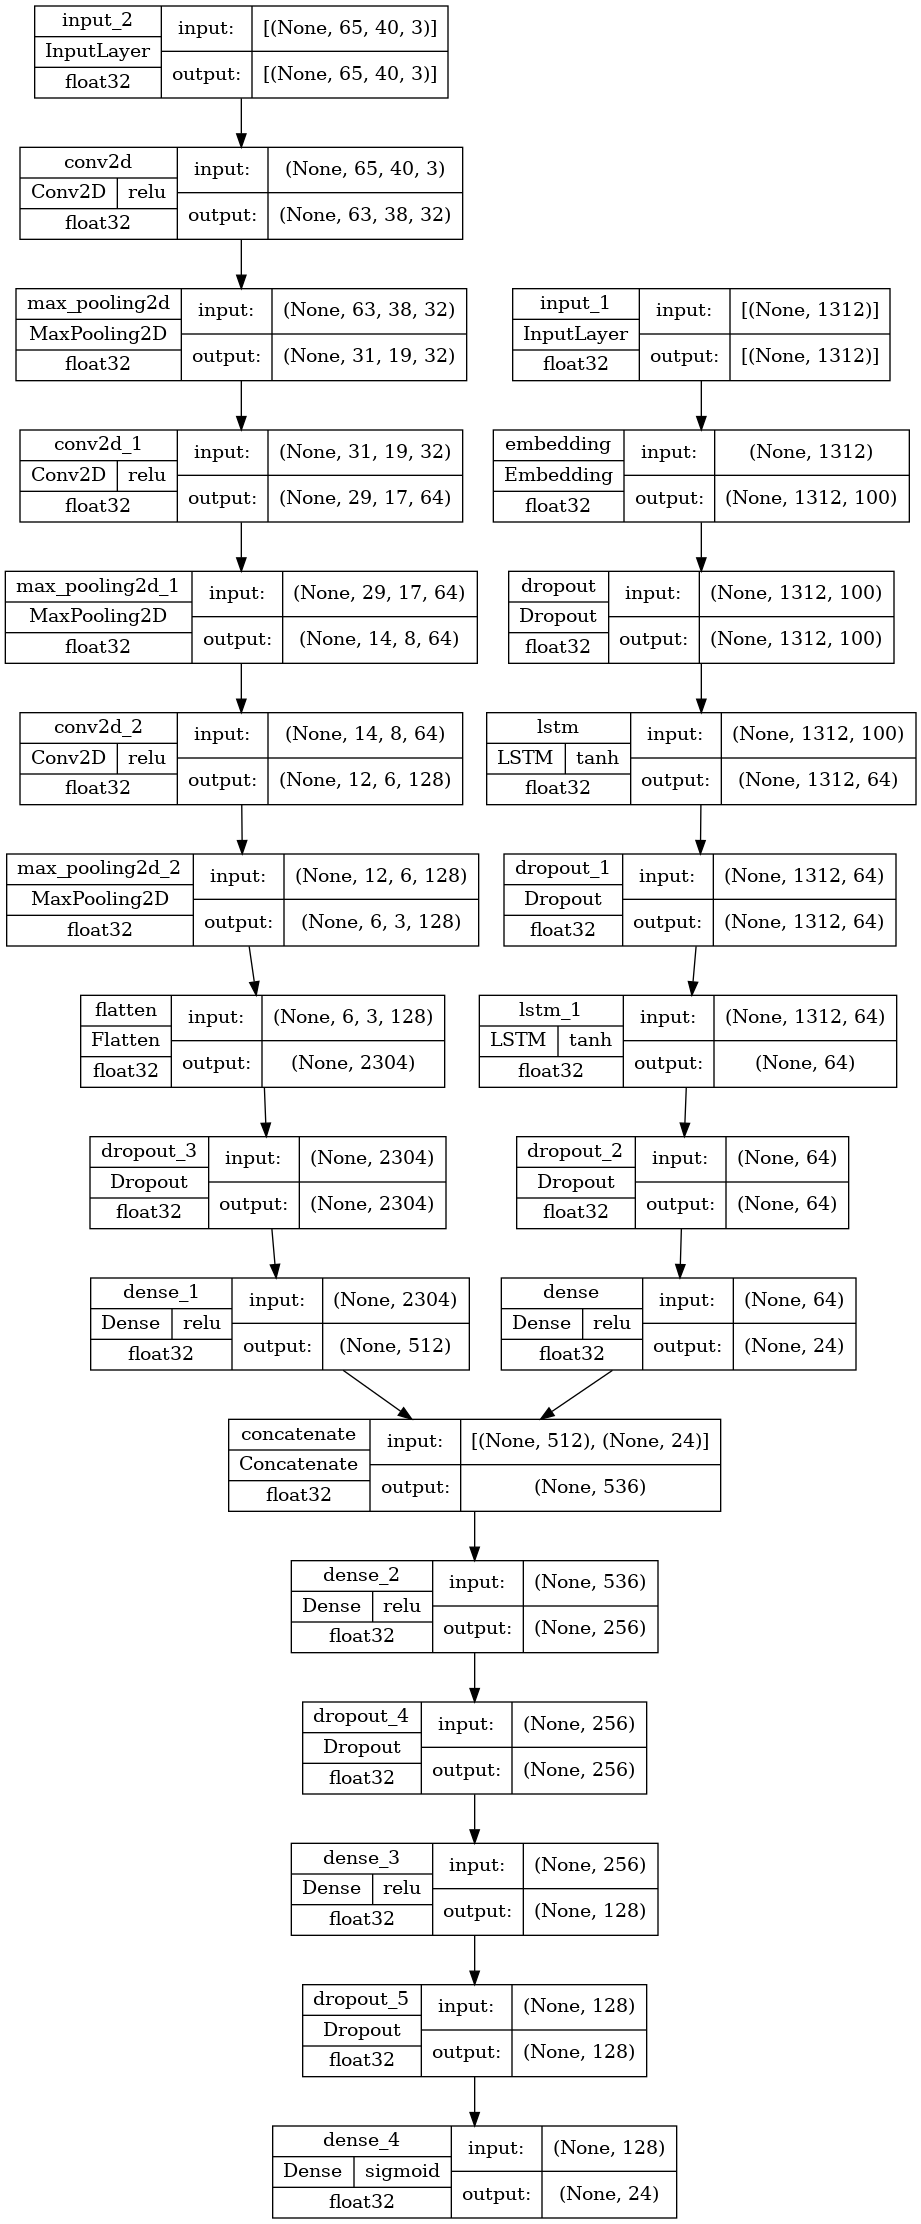

In [19]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, show_dtype=True, show_layer_activations=True) #, show_layer_activations=True

In [28]:
def compile_model(embedding_matrix):
    lstm_input = Input(shape=(max_sequence_length,))
    x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=max_sequence_length, trainable=False)(lstm_input)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences = True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    lstm_out = Dense(24, activation = 'relu')(x)

    print(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3])
    cnn_input = Input(shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))
    y = Conv2D(32, (3, 3), activation='relu', input_shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))(cnn_input)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(128, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    # y = Conv2D(128, (3, 3), activation='relu')(y)
    # y = MaxPooling2D(2, 2)(y)
    y = Flatten()(y)
    y = Dropout(0.3)(y)
    cnn_out = Dense(512, activation='relu')(y)

    concat_inp = concatenate([cnn_out, lstm_out])
    z = Dense(256, activation='relu')(concat_inp)
    z = Dropout(0.3)(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(train_labels.shape[1], activation='sigmoid')(z) # Sigmoid is crutial in multilabel classification

    model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
    adam = Adam(learning_rate=0.001, decay=1e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['categorical_accuracy']) # Скорее всего правильнее будет 'categorical accuracy', а не просто accuracy
    return model

In [29]:
model = compile_model(embedding_matrix)
model.summary()

2022-11-20 11:15:52.201977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 11:15:52.416969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marykorol/ind_lab2/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-20 11:15:52.417040: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-20 11:15:52.418885: I tensorflow/core/platform/cpu_featu

65 40 3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65, 40, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 63, 38, 32)   896         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 31, 19, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 input_1 (InputLayer)           [(None, 1312)]       0           []                               
                                                                                      

In [30]:
es = EarlyStopping(patience=5)
csv_logger = CSVLogger('./Multimodels/model_history_log.csv', append=True)
check_point = ModelCheckpoint(filepath='./Multimodels/best_model_todate', save_best_only=True, save_weights_only=True)

In [31]:
history= model.fit([train_np_imgs, X_text_train], train_labels, batch_size=100, epochs=200,
                            validation_data=([val_np_imgs, X_text_val], val_labels), callbacks = [es, csv_logger, check_point])

Epoch 1/200


2022-11-20 11:15:54.639172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160492800 exceeds 10% of free system memory.


52/52 [==============================] - 171s 3s/step - loss: 0.3146 - categorical_accuracy: 0.0435 - val_loss: 0.2563 - val_categorical_accuracy: 0.0280
Epoch 2/200
52/52 [==============================] - 169s 3s/step - loss: 0.2659 - categorical_accuracy: 0.0469 - val_loss: 0.2513 - val_categorical_accuracy: 0.0542
Epoch 3/200
52/52 [==============================] - 171s 3s/step - loss: 0.2593 - categorical_accuracy: 0.0538 - val_loss: 0.2488 - val_categorical_accuracy: 0.0664
Epoch 4/200
52/52 [==============================] - 174s 3s/step - loss: 0.2551 - categorical_accuracy: 0.0612 - val_loss: 0.2475 - val_categorical_accuracy: 0.1049
Epoch 5/200
52/52 [==============================] - 170s 3s/step - loss: 0.2511 - categorical_accuracy: 0.0799 - val_loss: 0.2465 - val_categorical_accuracy: 0.0892
Epoch 6/200
52/52 [==============================] - 167s 3s/step - loss: 0.2473 - categorical_accuracy: 0.0931 - val_loss: 0.2424 - val_categorical_accuracy: 0.1329
Epoch 7/200
52/5

In [32]:
model.save('./Multimodels/model.h5')
model.save_weights('./Multimodels/model_weights.h5')

# Model Evaluation

In [33]:
history = pd.read_csv('./Multimodels/model_history_log.csv')
history

,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.043546,0.314603,0.027972,0.256303
1,1,0.046851,0.265899,0.054196,0.251287
2,2,0.053849,0.259336,0.066434,0.248805
3,3,0.061236,0.255144,0.104895,0.247512
4,4,0.079899,0.251145,0.089161,0.246495
5,5,0.093118,0.247341,0.132867,0.242365
6,6,0.107893,0.243562,0.122378,0.240379
7,7,0.122667,0.240120,0.118881,0.238365
8,8,0.131610,0.237046,0.118881,0.239561
9,9,0.136081,0.233388,0.148601,0.235083


In [34]:
def plot_loss(history):
  if type(history) == pd.core.frame.DataFrame:
      plt.title('Loss')
      plt.plot(history['loss'], label='train')
      plt.plot(history['val_loss'], label='test')
      plt.legend(['training loss', 'validation loss'], loc='upper right')
  else:
      plt.title('Loss')
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='test')
      plt.legend(['training loss', 'validation loss'], loc='upper right') 

  plt.show()



def plot_acc(history):
  if type(history) == pd.core.frame.DataFrame:
    plt.title('Accuracy')
    plt.plot(history['categorical_accuracy'], label='train')
    plt.plot(history['val_categorical_accuracy'], label='test')
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.show()
  else:
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], label='train')
    plt.plot(history.history['val_categorical_accuracy'], label='test')
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.show()

  plt.show()    

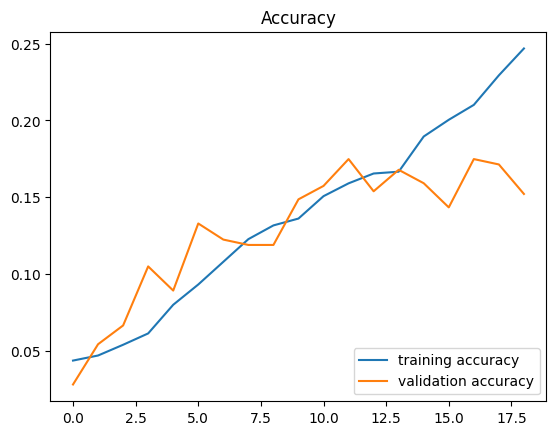

In [35]:
plot_acc(history)

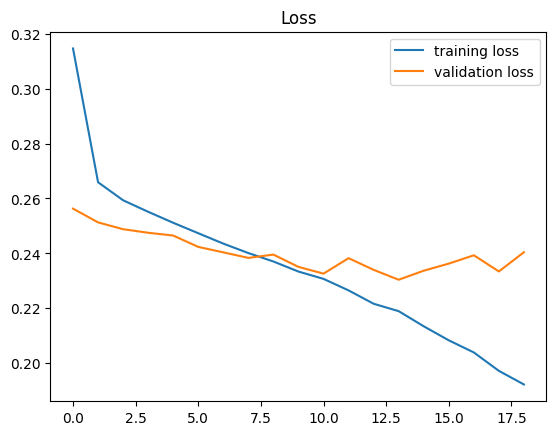

In [36]:
plot_loss(history)

Пока что, если сравнивать с LSTM, обучающейся только на текстах, здесь accuracy повышается медленнее: менее, чем на 10 % за 10 эпох. Однако надо посмотреть на большем количестве эпох, ведь в text-LSTM модель перестаёт обучаться новому примерно на 20й эпохе. Интересно, как будет здесь.

Наша задача - Multilabel classification (не путать с Multiclass classification)

Что касается метрики accuracy в целом: она слишком строга для задачи One vs Rest, так как требует совпадения по всем классам сразу.

# Inference

In [37]:
out = model.predict([test_np_imgs, X_text_test], batch_size=100)
roc_auc = roc_auc_score(test_labels, out)
print(roc_auc)

15/15 [==============================] - 18s 958ms/step
0.7112594181173596


In [38]:
y_pred = np.zeros(out.shape)
y_pred[out>0.05]=1
y_pred = np.array(y_pred)

In [45]:
t = 0.15  # threshold value

y_pred_new = np.zeros(out.shape)
y_pred_new[out > t] = 1

# evaluate performance
f1_score(test_labels, y_pred_new, average = 'micro') #samples - ?
#f1_score(y_test, y_pred_new, average="micro")

0.2401087284808215

In [47]:
id_predict = {}
j = 0
for i in idx_test:
    id_predict[i] = y_pred_new[j]
    j += 1

In [49]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Movie:  Remember Me 
Predicted genre:  [()]
Actual genre:  ['romance'] 

Plot: A romantic drama centered on two new lovers: Tyler, whose parents have split in the wake of his brother's suicide, and Ally, who lives each day to the fullest since witnessing her mother's murder.


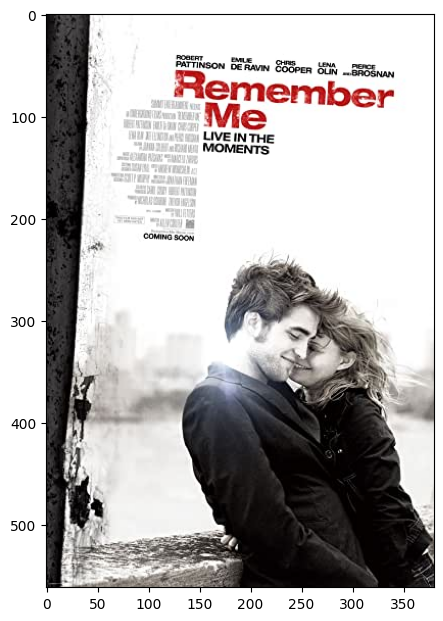

In [50]:
# Inference
#np.random.seed(2022)

def inference(k):
    q_pred = id_predict[k]
    return mlb.inverse_transform(np.array([q_pred]))


for i in range(1):
    k = np.random.choice(idx_test)
    print(
        "Movie: ",
        df["name"][k],
        "\nPredicted genre: ",
        inference(k),
    ), print("Actual genre: ", df["genres"][k], "\n")
    print('Plot:', df["description"][k])
    img = mpimg.imread(df.image_path[k])
    plt.figure(figsize = (5,10))
    plt.imshow(img)
    plt.show()

In [51]:
loss, acc = model.evaluate([test_np_imgs, X_text_test], test_labels, batch_size=100)
print("loss =", loss, ', accuracy =', acc)

15/15 [==============================] - 14s 959ms/step - loss: 0.2420 - categorical_accuracy: 0.1748
loss = 0.24195006489753723 , accuracy = 0.17482517659664154


In [52]:
hl = hamming_loss(test_labels,y_pred_new)
score = accuracy_score(test_labels, y_pred_new)
precision = precision_score(test_labels,y_pred_new, average = 'micro')
recall = recall_score(test_labels,y_pred_new, average = 'micro')
f1 = f1_score(test_labels,y_pred_new, average = 'micro')
print("Hamming loss:", hl)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Hamming loss: 0.14662004662004663
score: 0.026573426573426574
Precision: 0.18838862559241706
Recall: 0.3309741881765196
F1_score: 0.2401087284808215


In [ ]:
# from sklearn.metrics import matthews_corrcoef
# y_test = test_labels
# y_pred = np.zeros(out.shape)
# y_pred = np.array(y_pred) 
# threshold = np.arange(0.01, 0.90, 0.20)

# acc = []
# accuracies = []
# best_threshold = np.zeros(out.shape[1])
# for i in range(out.shape[1]):
#   y_prob = np.array(out[:,i])
#   for j in threshold:
#     y_pred = [1 if prob>=j else 0 for prob in y_prob]
#     y_pred = np.array(y_pred)
#     mcc = matthews_corrcoef(y_test[:,i],y_pred)
#     acc.append(mcc)
#   acc   = np.array(acc)
#   index = np.where(acc==acc.max())
#   accuracies.append(acc.max())
#   best_threshold[i] = threshold[index[0][0]]
#   acc = []

# y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])   

In [53]:
preds = np.transpose(y_pred_new)
labels = np.transpose(test_labels)

action
accuracy: 0.8496503496503497 precision: 0.1870967741935484 recall: 0.2457627118644068 f1: 0.21245421245421245


<Figure size 640x480 with 0 Axes>

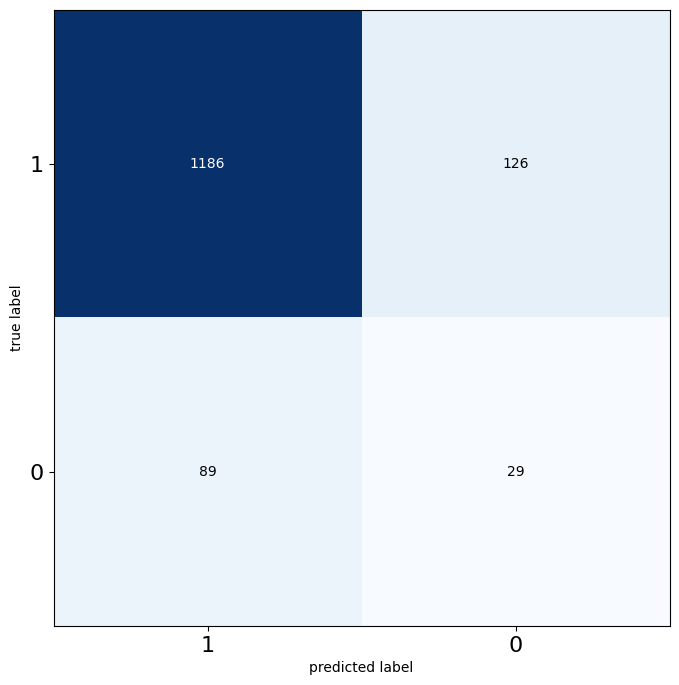

adventure
accuracy: 0.8552447552447553 precision: 0.15602836879432624 recall: 0.2 f1: 0.1752988047808765


<Figure size 640x480 with 0 Axes>

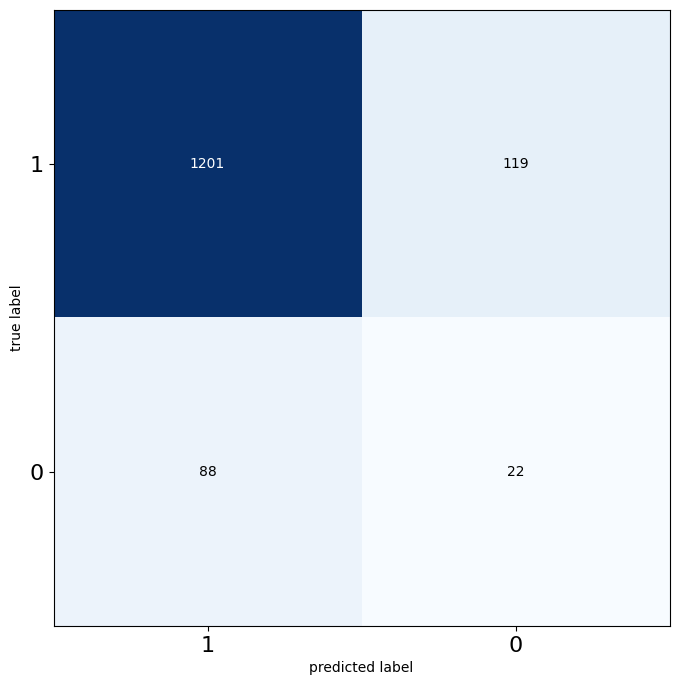

animation
accuracy: 0.8440559440559441 precision: 0.25116279069767444 recall: 0.46551724137931033 f1: 0.32628398791540786


<Figure size 640x480 with 0 Axes>

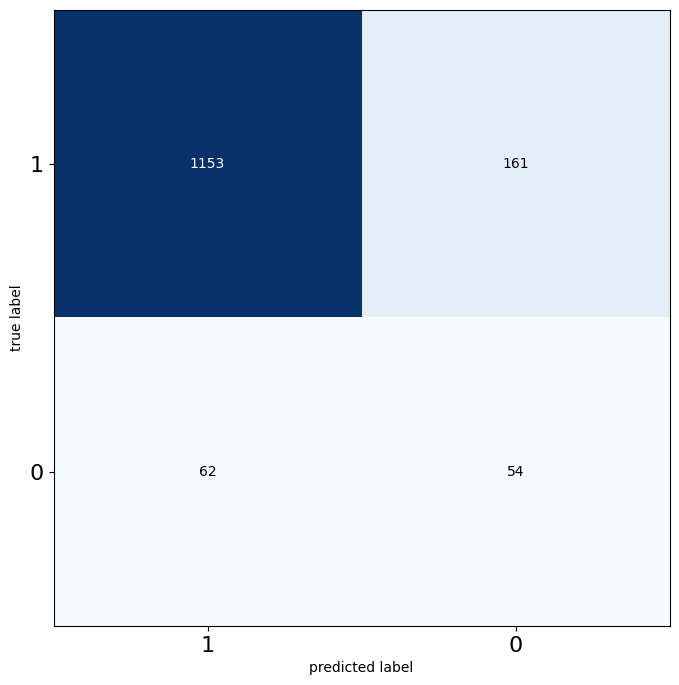

biography
accuracy: 0.8020979020979021 precision: 0.15807560137457044 recall: 0.5476190476190477 f1: 0.24533333333333335


<Figure size 640x480 with 0 Axes>

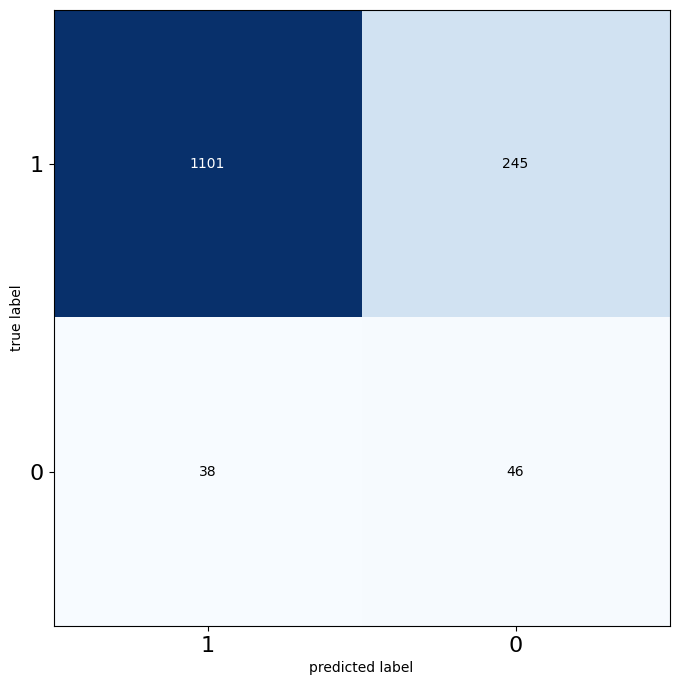

comedy
accuracy: 0.8349650349650349 precision: 0.11764705882352941 recall: 0.23655913978494625 f1: 0.15714285714285714


<Figure size 640x480 with 0 Axes>

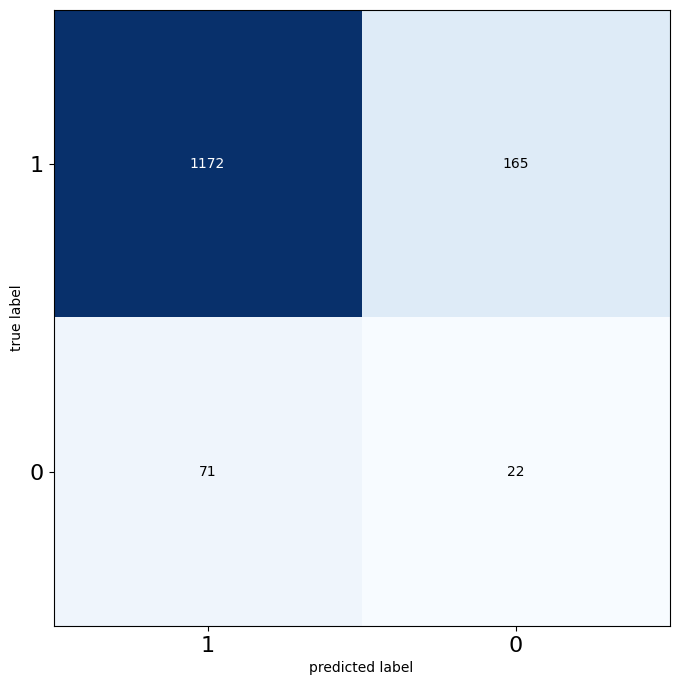

crime
accuracy: 0.7783216783216783 precision: 0.11864406779661017 recall: 0.3804347826086957 f1: 0.18087855297157623


<Figure size 640x480 with 0 Axes>

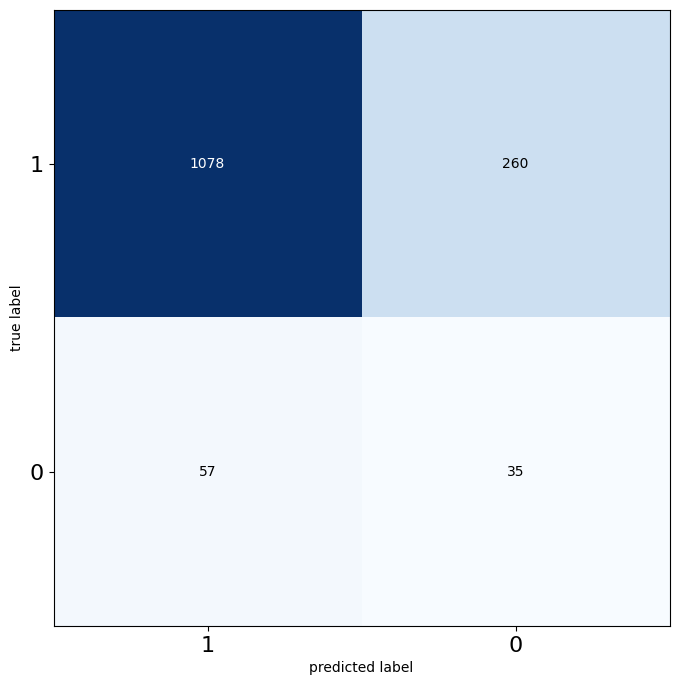

documentary
accuracy: 0.83006993006993 precision: 0.19491525423728814 recall: 0.46464646464646464 f1: 0.2746268656716418


<Figure size 640x480 with 0 Axes>

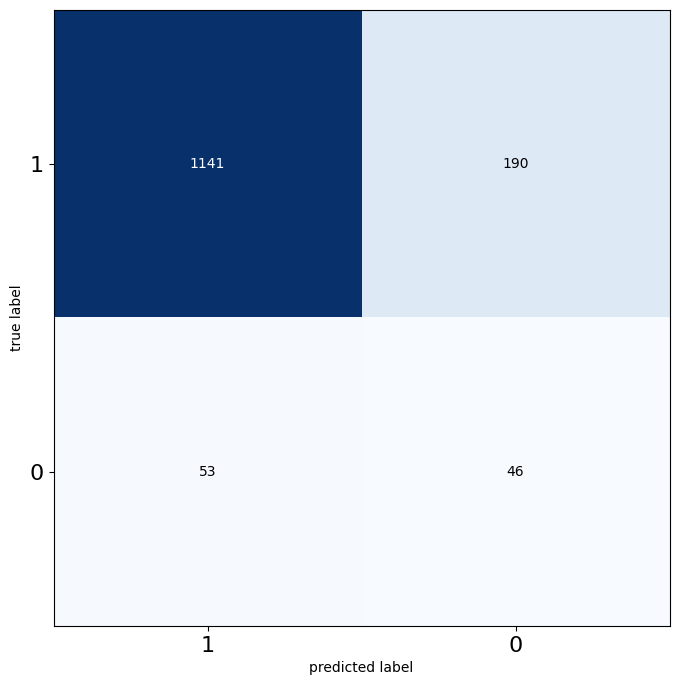

drama
accuracy: 0.8188811188811189 precision: 0.12322274881516587 recall: 0.26 f1: 0.16720257234726688


<Figure size 640x480 with 0 Axes>

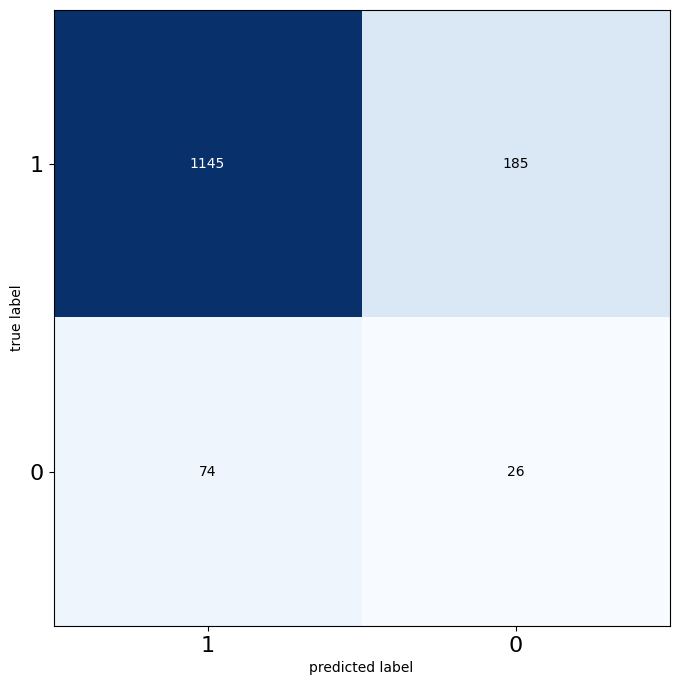

family
accuracy: 0.8405594405594405 precision: 0.2097560975609756 recall: 0.3944954128440367 f1: 0.27388535031847133


<Figure size 640x480 with 0 Axes>

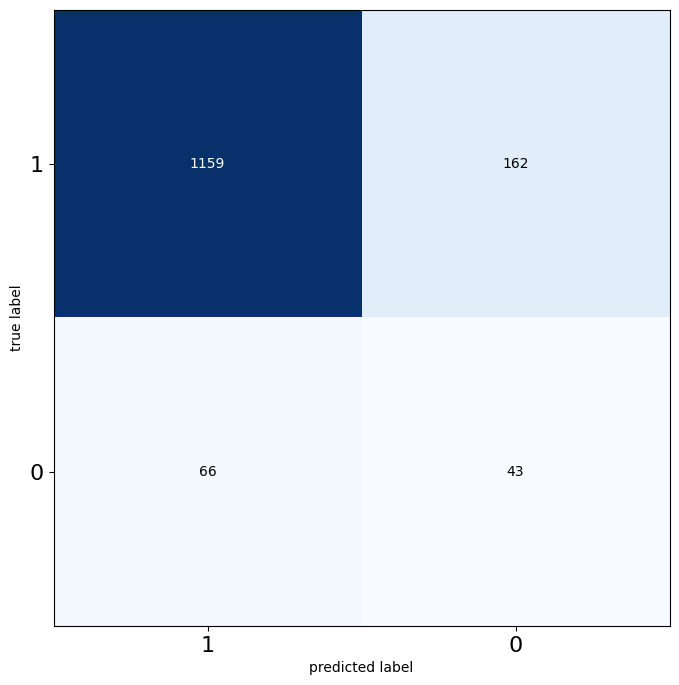

fantasy
accuracy: 0.8566433566433567 precision: 0.1079136690647482 recall: 0.15625 f1: 0.1276595744680851


<Figure size 640x480 with 0 Axes>

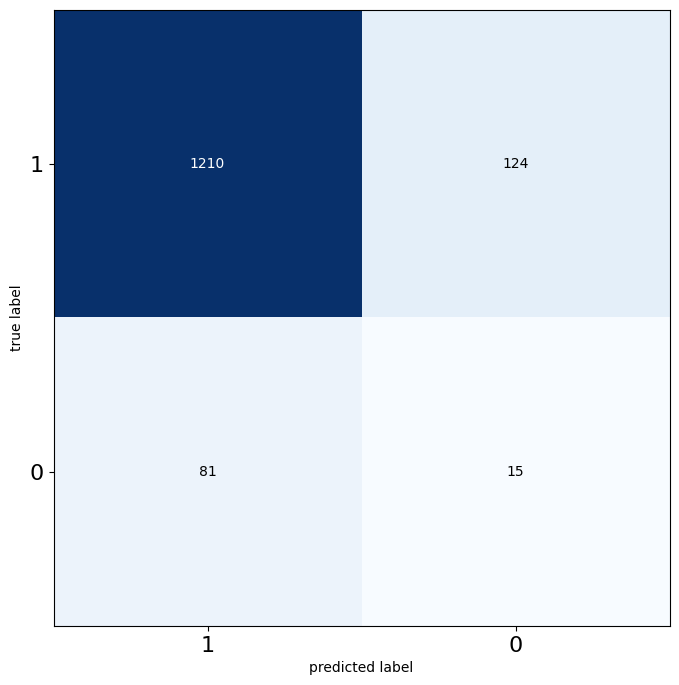

film noir
accuracy: 0.913986013986014 precision: 0.44171779141104295 recall: 0.6923076923076923 f1: 0.5393258426966293


<Figure size 640x480 with 0 Axes>

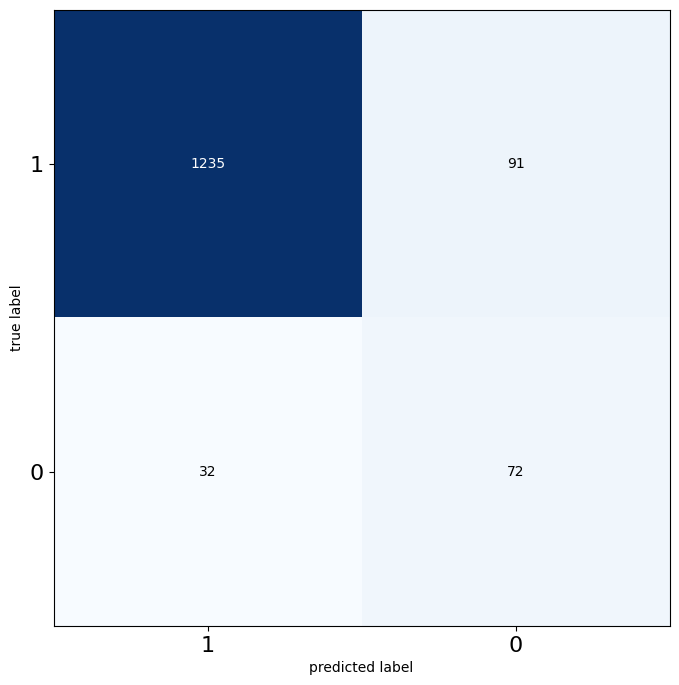

history
accuracy: 0.8594405594405594 precision: 0.20359281437125748 recall: 0.3333333333333333 f1: 0.2527881040892193


<Figure size 640x480 with 0 Axes>

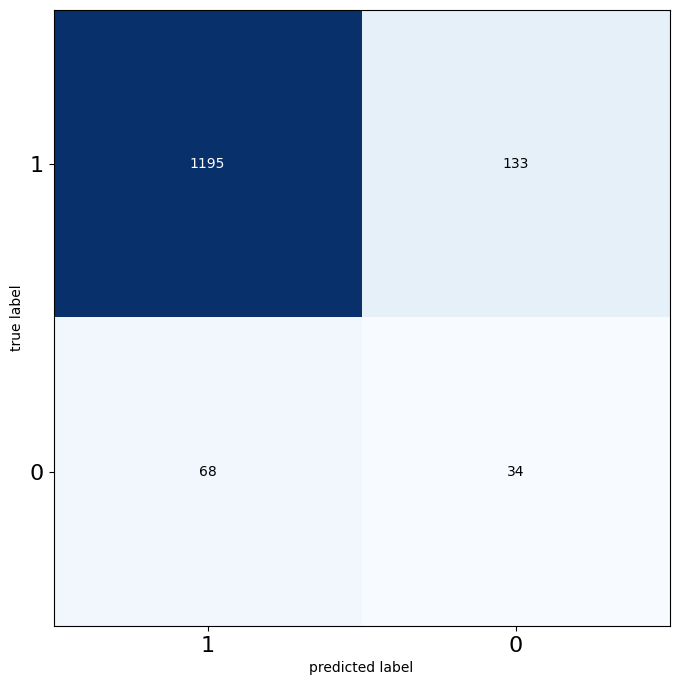

horror
accuracy: 0.8699300699300699 precision: 0.20689655172413793 recall: 0.42857142857142855 f1: 0.2790697674418604


<Figure size 640x480 with 0 Axes>

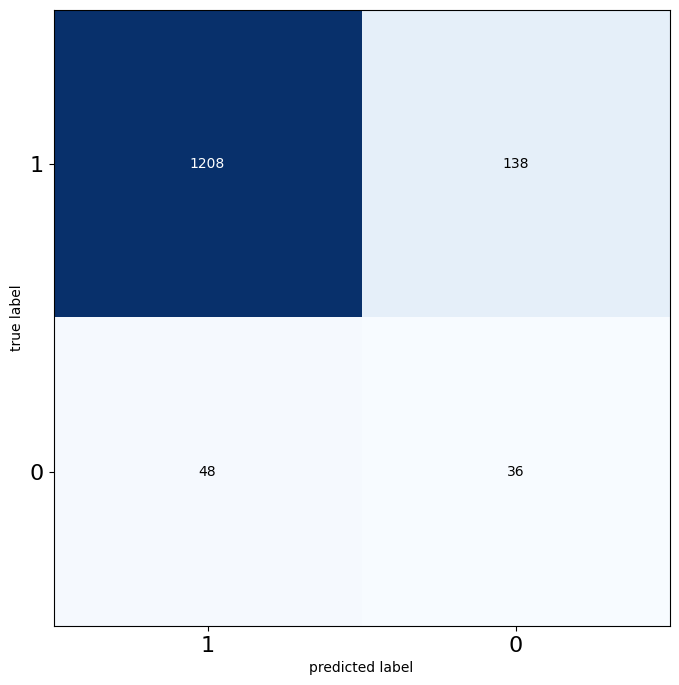

music
accuracy: 0.9146853146853147 precision: 0.17142857142857143 recall: 0.06060606060606061 f1: 0.08955223880597014


<Figure size 640x480 with 0 Axes>

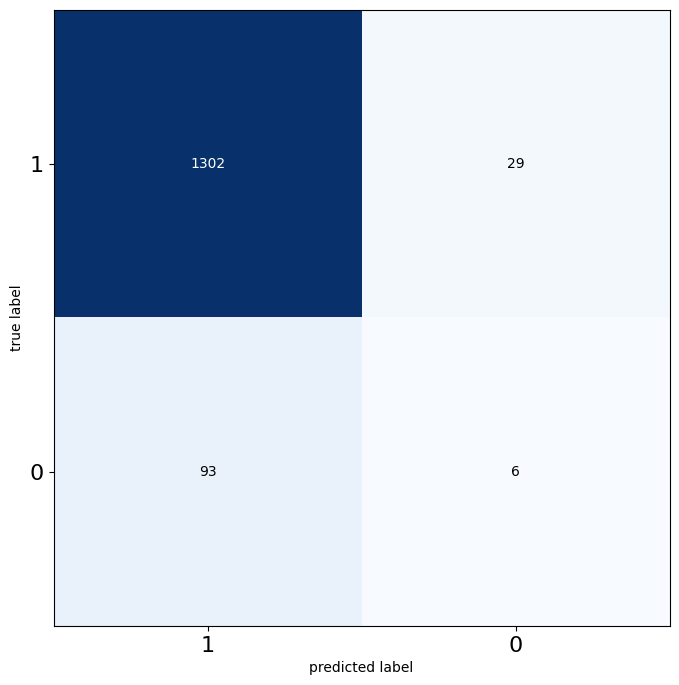

musical
accuracy: 0.8335664335664336 precision: 0.20883534136546184 recall: 0.5591397849462365 f1: 0.30409356725146197


<Figure size 640x480 with 0 Axes>

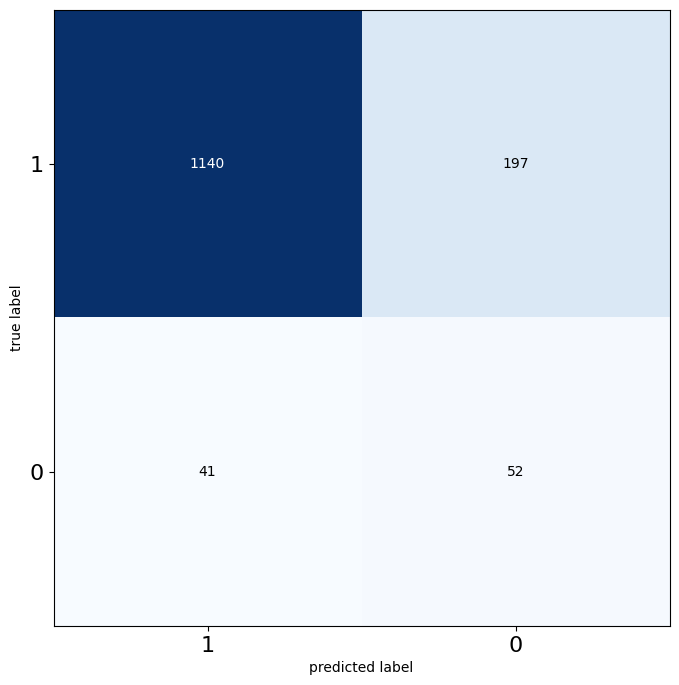

mystery
accuracy: 0.8405594405594405 precision: 0.19704433497536947 recall: 0.38095238095238093 f1: 0.25974025974025977


<Figure size 640x480 with 0 Axes>

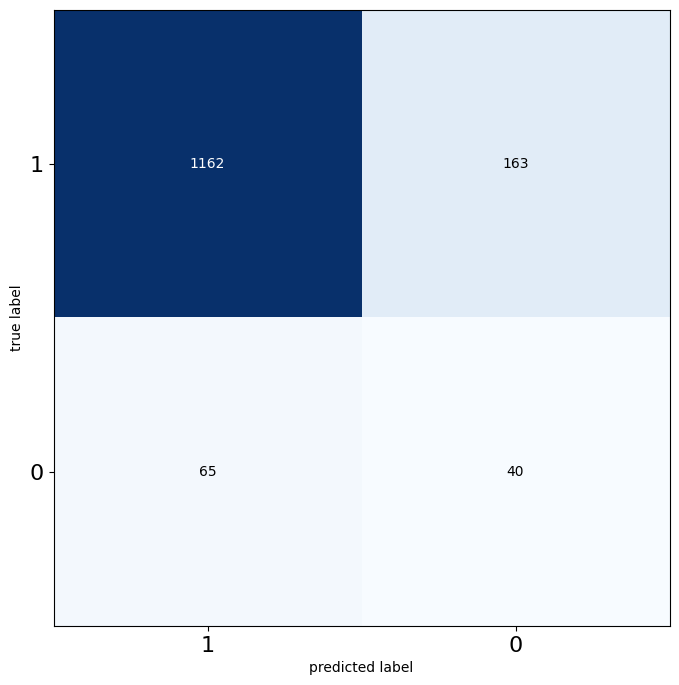

romance
accuracy: 0.8944055944055944 precision: 0.07272727272727272 recall: 0.038461538461538464 f1: 0.050314465408805034


<Figure size 640x480 with 0 Axes>

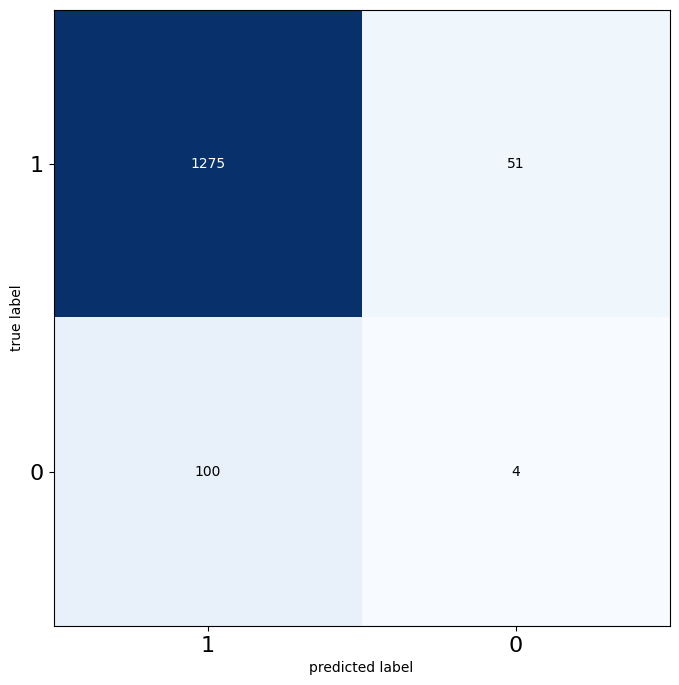

sci-fi
accuracy: 0.8538461538461538 precision: 0.1625 recall: 0.25742574257425743 f1: 0.1992337164750958


<Figure size 640x480 with 0 Axes>

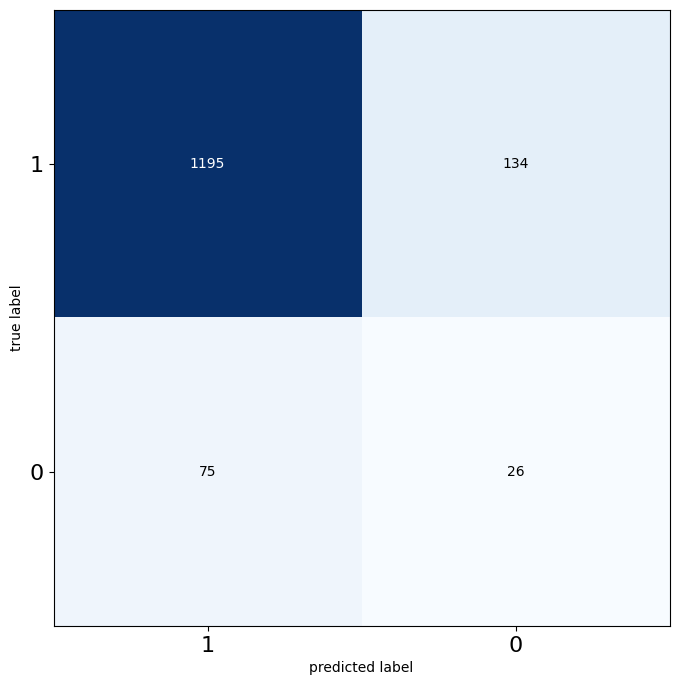

short film
accuracy: 0.8202797202797203 precision: 0.16738197424892703 recall: 0.38235294117647056 f1: 0.23283582089552238


<Figure size 640x480 with 0 Axes>

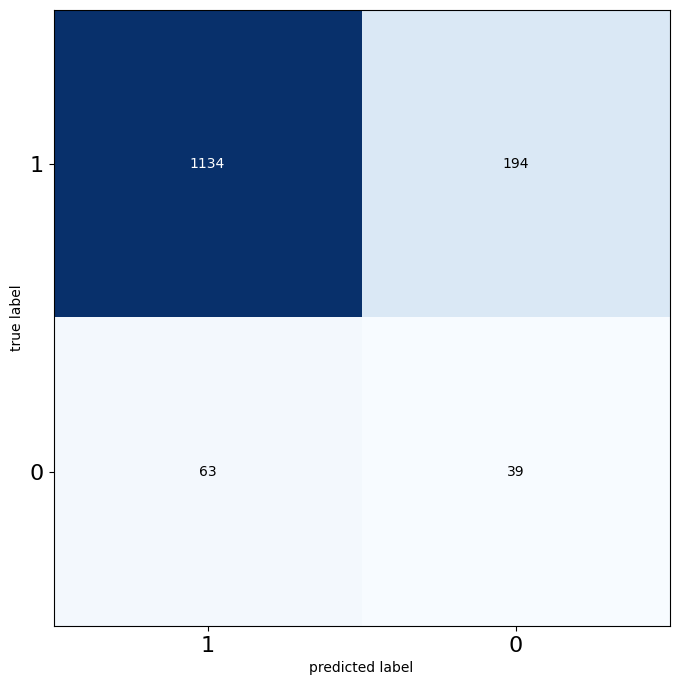

sport
accuracy: 0.913986013986014 precision: 0.058823529411764705 recall: 0.021505376344086023 f1: 0.031496062992125984


<Figure size 640x480 with 0 Axes>

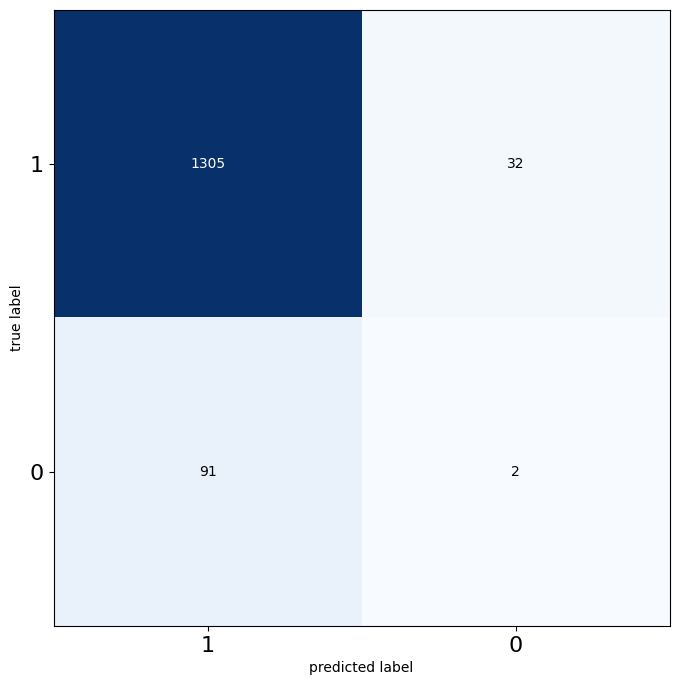

superhero
accuracy: 0.8727272727272727 precision: 0.20270270270270271 recall: 0.3191489361702128 f1: 0.24793388429752064


<Figure size 640x480 with 0 Axes>

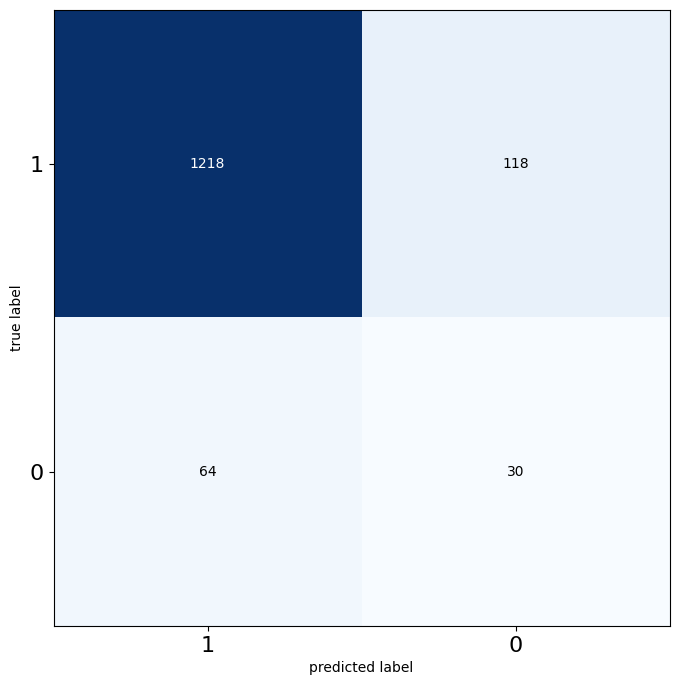

thriller
accuracy: 0.8293706293706293 precision: 0.1552511415525114 recall: 0.3655913978494624 f1: 0.21794871794871795


<Figure size 640x480 with 0 Axes>

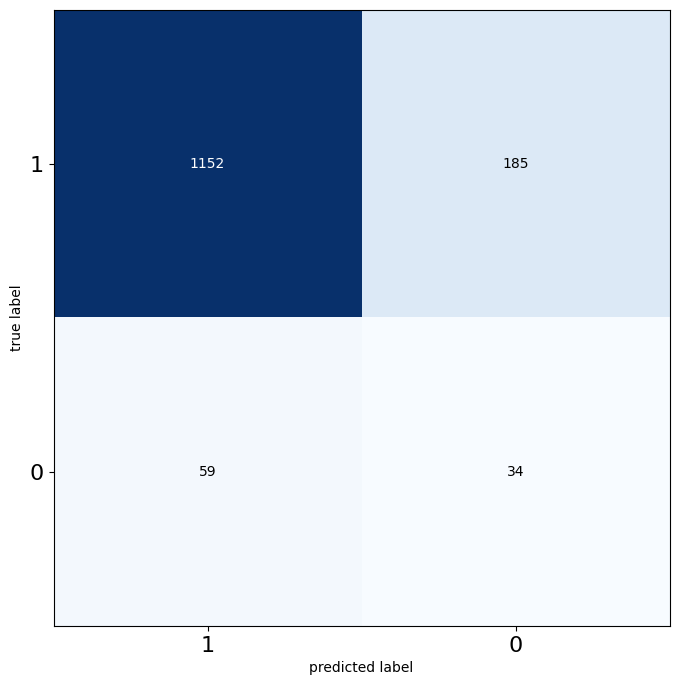

war
accuracy: 0.9055944055944056 precision: 0.4049586776859504 recall: 0.4375 f1: 0.42060085836909866


<Figure size 640x480 with 0 Axes>

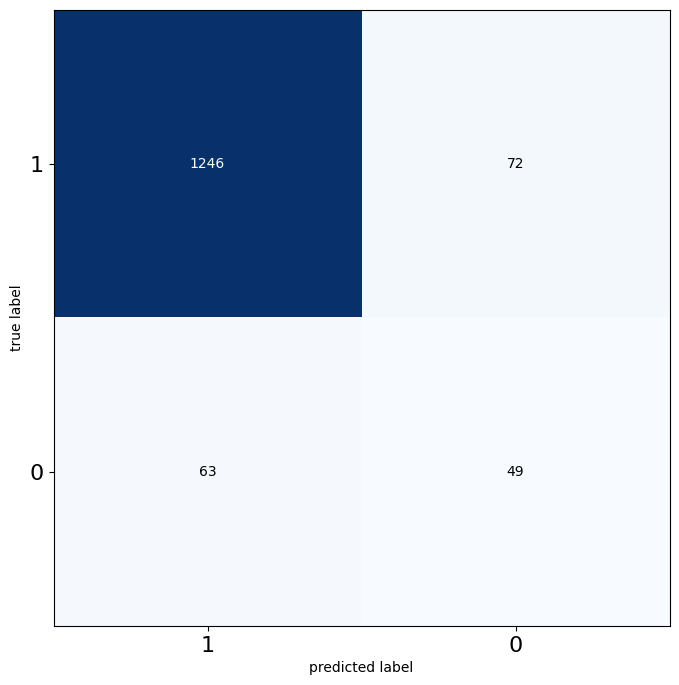

western
accuracy: 0.8482517482517482 precision: 0.1793478260869565 recall: 0.3333333333333333 f1: 0.2332155477031802


<Figure size 640x480 with 0 Axes>

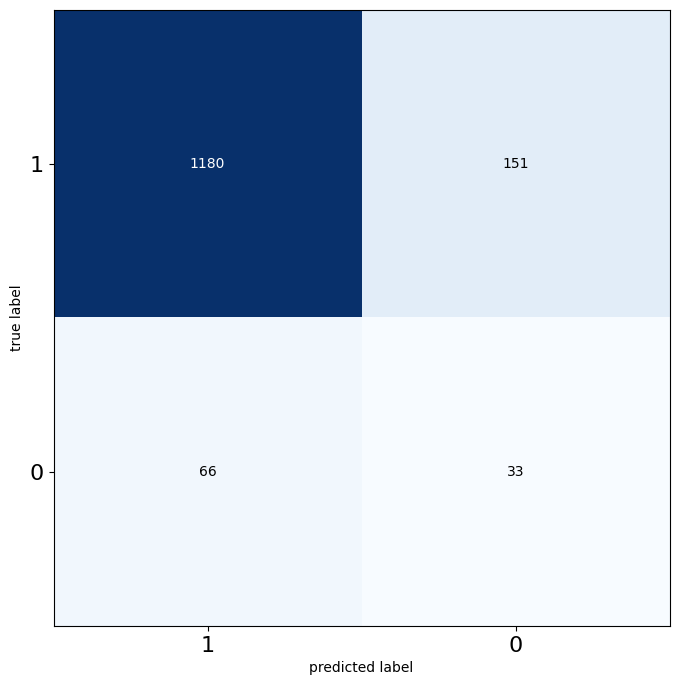

In [54]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
  # print(len(labels[i, :]), len(preds[i, :]))
  accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds[i, :]))
  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])
  cm  = confusion_matrix(labels[i, :], preds[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=16)
  plt.yticks(range(2), ['1', '0'], fontsize=16)
  plt.show()

In [ ]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.7498834498834498 Precision: 0.20751767673813326 Recall: 0.40197792067453264 f1: 0.20535349401099043


Пока что мы видим не супервнушительные результаты. Если выбрать повышение precision - то для объекта выборки будет выбрано слишком много жанров.
Модель также показывает переобучение примерно через 25 эпох, - срабатывает early stopping.
В дальнейшем можно дообучать ту же модель, а можно начать новую.

Что можно поменять:
- Другой оптимизатор
- Попробовать решить проблему Data imbalance
- Попробовать слегка другую схему

Можно ещё сделать так, что если ни одна из 24 вероятностей не превысила threshold, то сделать так, чтобы выдавался жанр с наибольшей предсказанной вероятностью - чтобы не было такой ситуации, когда модель ни единого жанра не выводит

# Another option

Changed the lstm_out and optimizer

In [55]:
def compile_mod_model(embedding_matrix):
    lstm_input = Input(shape=(max_sequence_length,))
    x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=max_sequence_length, trainable=False)(lstm_input)
    x = Dropout(0.5)(x)
    x = LSTM(64, return_sequences = True)(x)
    x = Dropout(0.5)(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    lstm_out = Dense(64, activation = 'relu')(x)

    print(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3])
    cnn_input = Input(shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))
    y = Conv2D(32, (3, 3), activation='relu', input_shape=(train_np_imgs.shape[1], train_np_imgs.shape[2], train_np_imgs.shape[3]))(cnn_input)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    y = Conv2D(128, (3, 3), activation='relu')(y)
    y = MaxPooling2D(2, 2)(y)
    # y = Conv2D(128, (3, 3), activation='relu')(y)
    # y = MaxPooling2D(2, 2)(y)
    y = Flatten()(y)
    y = Dropout(0.3)(y)
    cnn_out = Dense(512, activation='relu')(y)

    concat_inp = concatenate([cnn_out, lstm_out])
    z = Dense(256, activation='relu')(concat_inp)
    z = Dropout(0.3)(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(train_labels.shape[1], activation='sigmoid')(z) # Sigmoid is crutial in multilabel classification

    model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
    rmsprop = RMSprop(learning_rate=0.001, decay=1e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['categorical_accuracy']) # Скорее всего правильнее будет 'categorical accuracy', а не просто accuracy
    return model

In [56]:
model_mod = compile_mod_model(embedding_matrix)
model_mod.summary()

65 40 3
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 65, 40, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 38, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 31, 19, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 input_3 (InputLayer)           [(None, 1312)]       0           []                               
                                                                                    

In [58]:
es = EarlyStopping(patience=5)
csv_logger_mod = CSVLogger('./Multimodels/history_log_model_lstm_mod.csv', append=True)
check_point = ModelCheckpoint(filepath='./Multimodels/best_lstm_model_todate_mod', save_best_only=True, save_weights_only=True)
history_2 = model_mod.fit([train_np_imgs, X_text_train], train_labels, batch_size=100, epochs=200,
                            validation_data=([val_np_imgs, X_text_val], val_labels), callbacks = [es, csv_logger_mod, check_point])

Epoch 1/200
52/52 [==============================] - 179s 3s/step - loss: 0.3215 - categorical_accuracy: 0.0400 - val_loss: 0.2645 - val_categorical_accuracy: 0.0245
Epoch 2/200
52/52 [==============================] - 179s 3s/step - loss: 0.2769 - categorical_accuracy: 0.0447 - val_loss: 0.2550 - val_categorical_accuracy: 0.0507
Epoch 3/200
52/52 [==============================] - 176s 3s/step - loss: 0.2672 - categorical_accuracy: 0.0455 - val_loss: 0.2542 - val_categorical_accuracy: 0.0367
Epoch 4/200
52/52 [==============================] - 179s 3s/step - loss: 0.2603 - categorical_accuracy: 0.0519 - val_loss: 0.2571 - val_categorical_accuracy: 0.0682
Epoch 5/200
52/52 [==============================] - 179s 3s/step - loss: 0.2562 - categorical_accuracy: 0.0581 - val_loss: 0.2497 - val_categorical_accuracy: 0.0542
Epoch 6/200
52/52 [==============================] - 180s 3s/step - loss: 0.2529 - categorical_accuracy: 0.0675 - val_loss: 0.2466 - val_categorical_accuracy: 0.1171
Epoc

In [59]:
model_mod.save('./Multimodels/model_mod.h5')
model_mod.save_weights('./Multimodels/model_mod_weights.h5')

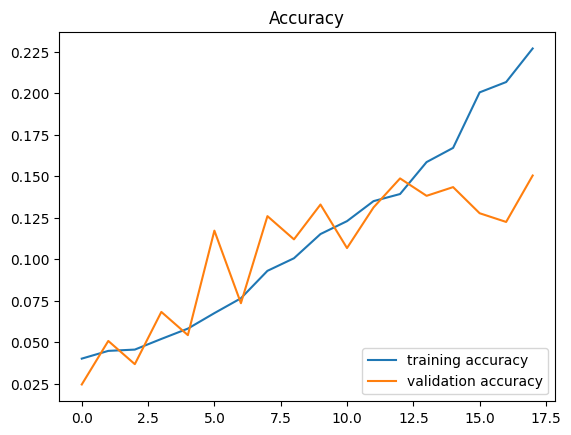

In [60]:
plot_acc(history_2)

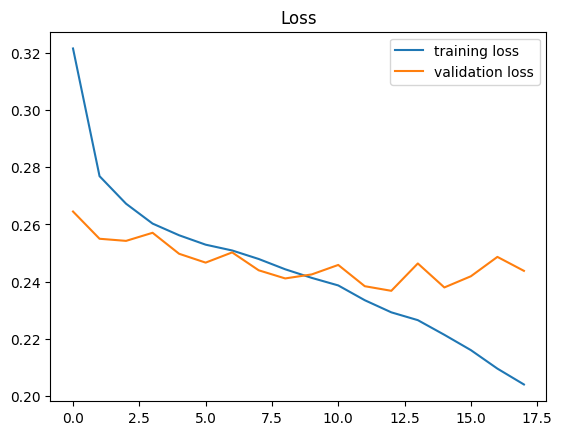

In [61]:
plot_loss(history_2)

In [62]:
loss, acc = model_mod.evaluate([test_np_imgs, X_text_test], test_labels, batch_size=100)
print("loss =", loss, 'accuracy =', acc)

15/15 [==============================] - 17s 1s/step - loss: 0.2489 - categorical_accuracy: 0.1364
loss = 0.24892117083072662 accuracy = 0.13636364042758942


In [63]:
out_2 = model_mod.predict([test_np_imgs, X_text_test], batch_size=100)
roc_auc = roc_auc_score(test_labels, out)
print(roc_auc)

15/15 [==============================] - 20s 1s/step
0.7112594181173596


In [64]:
y_pred_2 = np.zeros(out_2.shape)
y_pred_2[out_2>0.05]=1
y_pred_2 = np.array(y_pred_2)

In [73]:
t = 0.13  # threshold value

y_pred_new_2 = np.zeros(out.shape)
y_pred_new_2[out_2 > t] = 1

# evaluate performance
f1_score(test_labels, y_pred_new_2, average = 'micro') #samples - ?
#f1_score(y_test, y_pred_new, average="micro")

0.20420485175202155

In [74]:
id_predict = {}
j = 0
for i in idx_test:
    id_predict[i] = y_pred_new[j]
    j += 1

Movie:  Blackthorn 
Predicted genre:  [('biography', 'crime')]
Actual genre:  ['western'] 

Plot: In Bolivia, Butch Cassidy (now calling himself James Blackthorn) pines for one last sight of home, an adventure that aligns him with a young robber and makes the duo a target for gangs and lawmen alike.


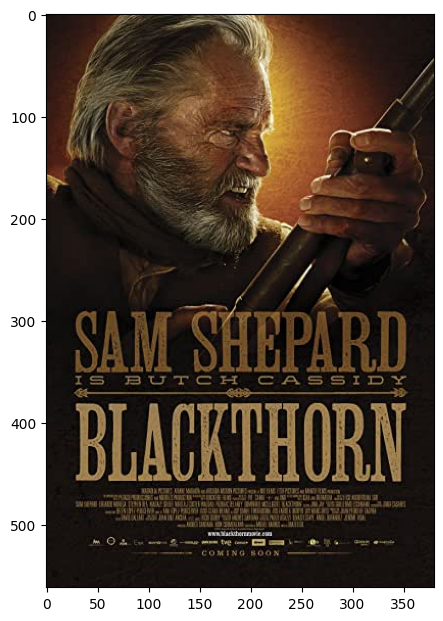

In [75]:
# Inference
#np.random.seed(2022)
def inference(k):
    q_pred = id_predict[k]
    return mlb.inverse_transform(np.array([q_pred]))


for i in range(1):
    k = np.random.choice(idx_test)
    print(
        "Movie: ",
        df["name"][k],
        "\nPredicted genre: ",
        inference(k),
    ), print("Actual genre: ", df["genres"][k], "\n")
    print('Plot:', df["description"][k])
    img = mpimg.imread(df.image_path[k])
    plt.figure(figsize = (5,10))
    plt.imshow(img)
    plt.show()

In [76]:
preds_2 = np.transpose(y_pred_new_2)
labels = np.transpose(test_labels)

In [77]:
hl = hamming_loss(test_labels,y_pred_new_2)
score = accuracy_score(test_labels, y_pred_new_2)
precision = precision_score(test_labels,y_pred_new_2, average = 'micro')
recall = recall_score(test_labels,y_pred_new_2, average = 'micro')
f1 = f1_score(test_labels,y_pred_new_2, average = 'micro')
print("Hamming loss:", hl)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Hamming loss: 0.21506410256410258
score: 0.002797202797202797
Precision: 0.13778553761094137
Recall: 0.3942547876769359
F1_score: 0.20420485175202155


action
accuracy: 0.8657342657342657 precision: 0.20634920634920634 recall: 0.22033898305084745 f1: 0.21311475409836064


<Figure size 640x480 with 0 Axes>

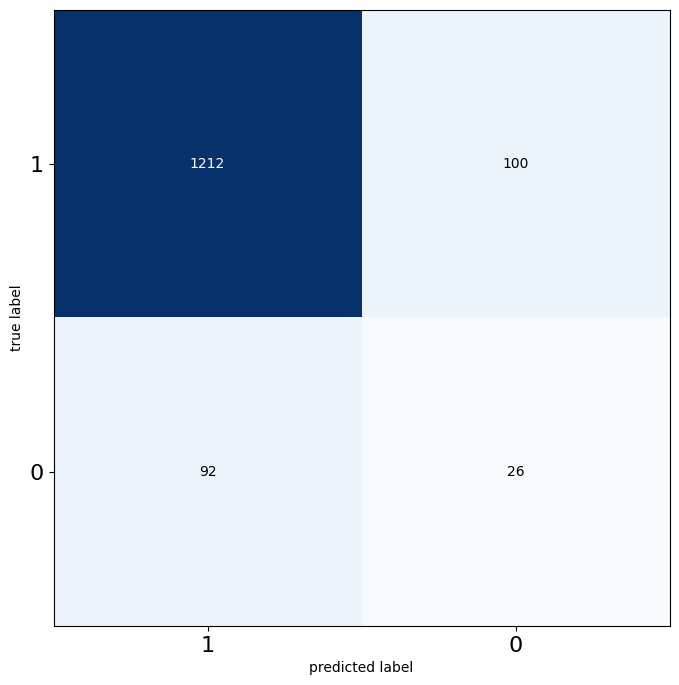

adventure
accuracy: 0.8734265734265734 precision: 0.1743119266055046 recall: 0.17272727272727273 f1: 0.17351598173515984


<Figure size 640x480 with 0 Axes>

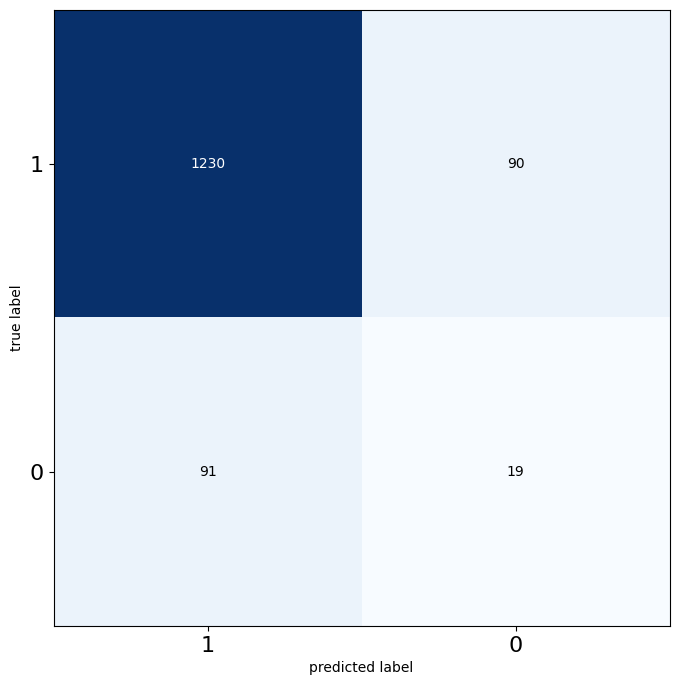

animation
accuracy: 0.8482517482517482 precision: 0.2512315270935961 recall: 0.4396551724137931 f1: 0.31974921630094044


<Figure size 640x480 with 0 Axes>

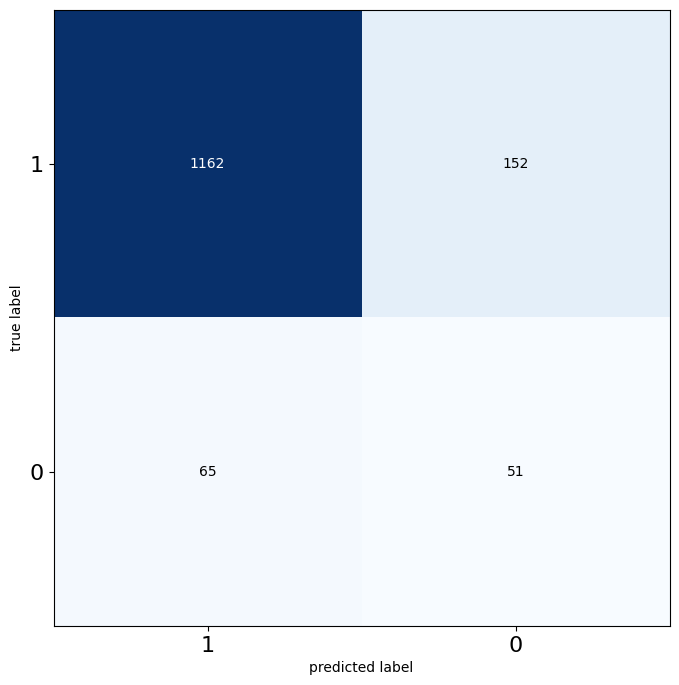

biography
accuracy: 0.6377622377622377 precision: 0.09814814814814815 recall: 0.6309523809523809 f1: 0.1698717948717949


<Figure size 640x480 with 0 Axes>

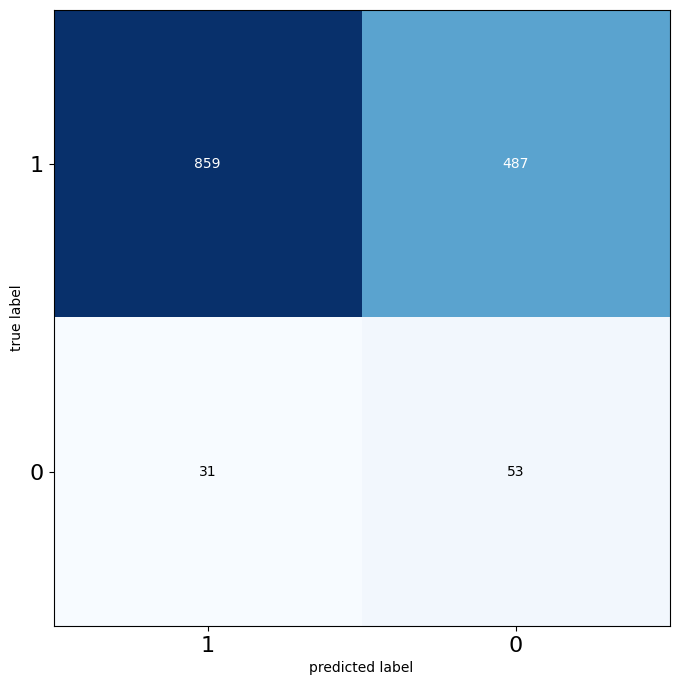

comedy
accuracy: 0.820979020979021 precision: 0.14096916299559473 recall: 0.34408602150537637 f1: 0.20000000000000004


<Figure size 640x480 with 0 Axes>

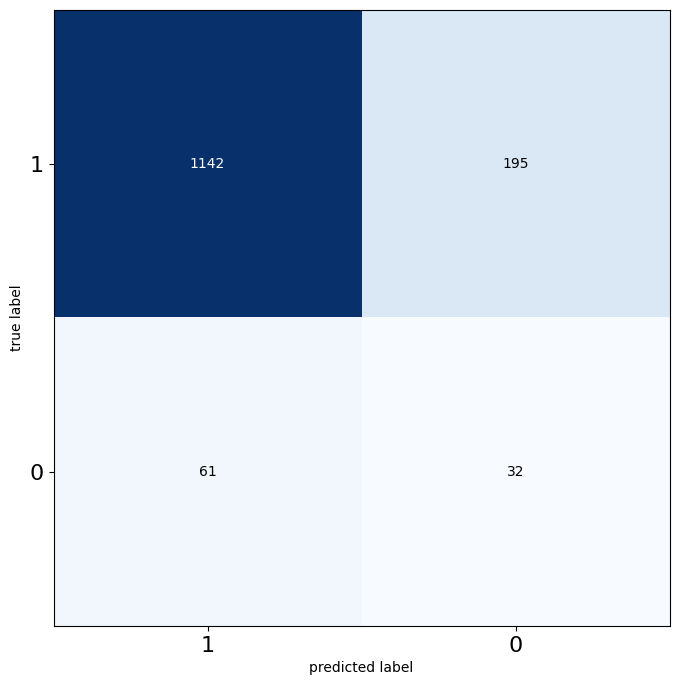

crime
accuracy: 0.7090909090909091 precision: 0.12149532710280374 recall: 0.5652173913043478 f1: 0.2


<Figure size 640x480 with 0 Axes>

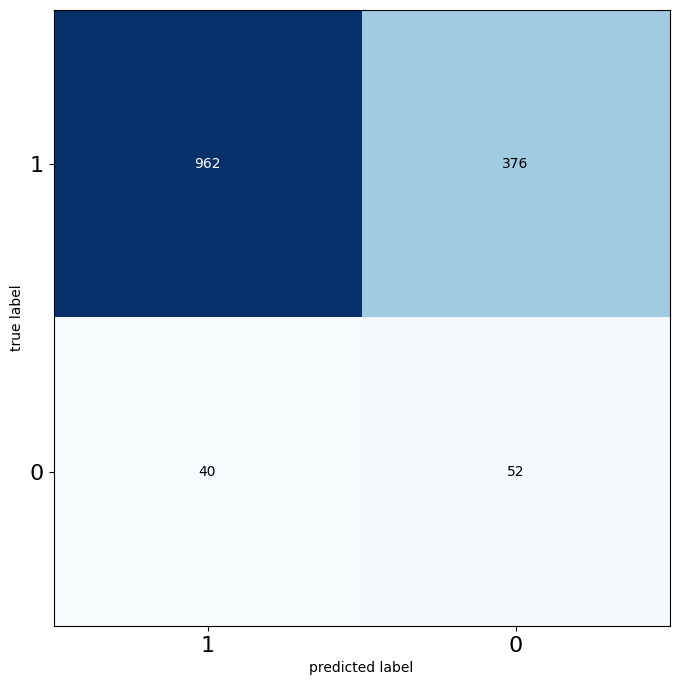

documentary
accuracy: 0.7272727272727273 precision: 0.145985401459854 recall: 0.6060606060606061 f1: 0.23529411764705882


<Figure size 640x480 with 0 Axes>

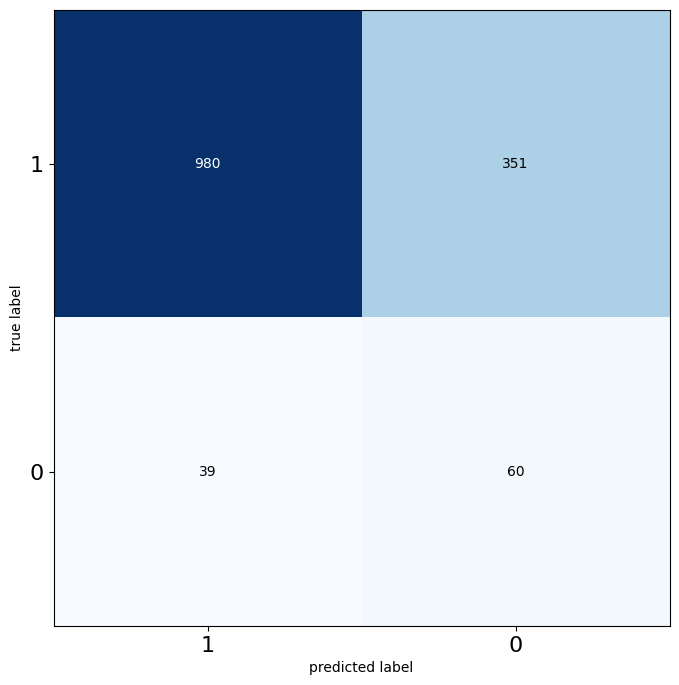

drama
accuracy: 0.6783216783216783 precision: 0.12025316455696203 recall: 0.57 f1: 0.19860627177700352


<Figure size 640x480 with 0 Axes>

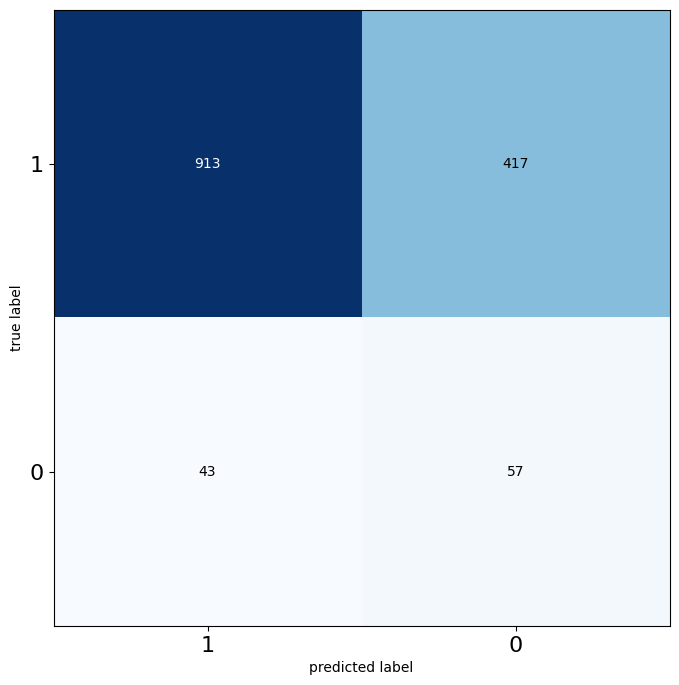

family
accuracy: 0.8293706293706293 precision: 0.2 recall: 0.41284403669724773 f1: 0.2694610778443114


<Figure size 640x480 with 0 Axes>

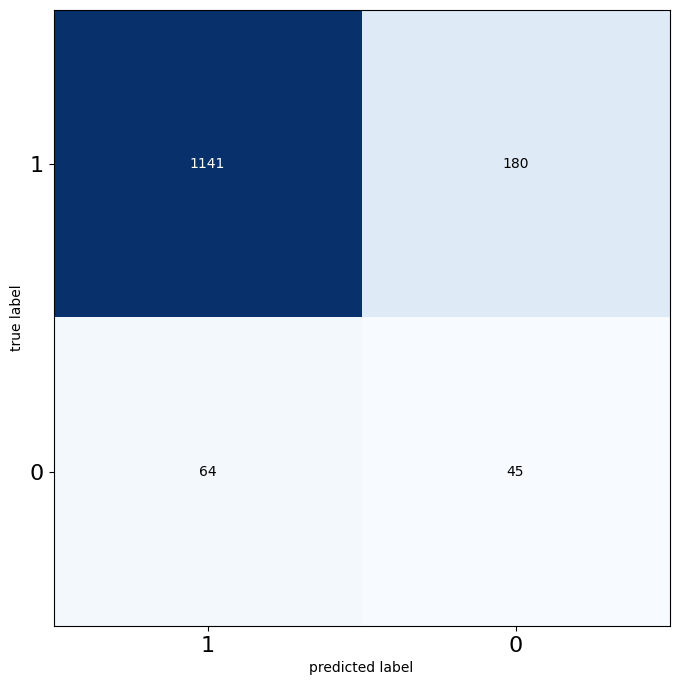

fantasy
accuracy: 0.8398601398601399 precision: 0.13259668508287292 recall: 0.25 f1: 0.17328519855595667


<Figure size 640x480 with 0 Axes>

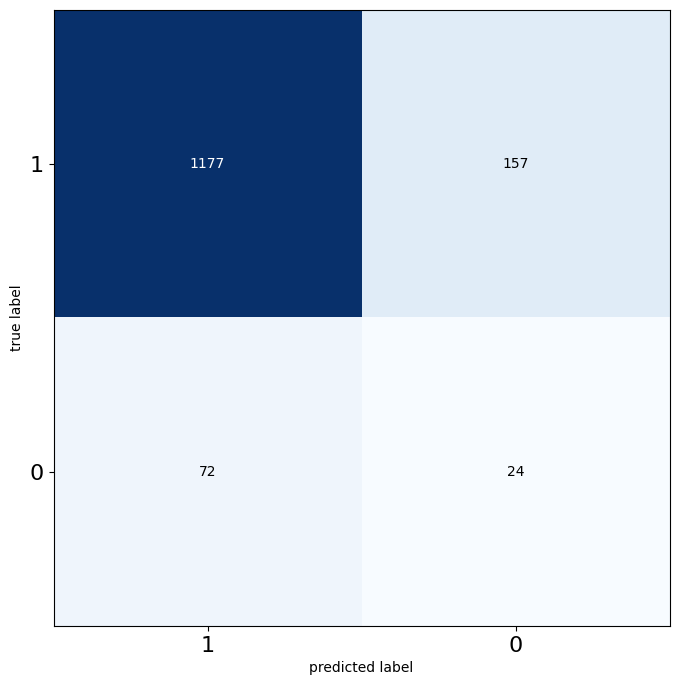

film noir
accuracy: 0.9265734265734266 precision: 0.49333333333333335 recall: 0.3557692307692308 f1: 0.4134078212290503


<Figure size 640x480 with 0 Axes>

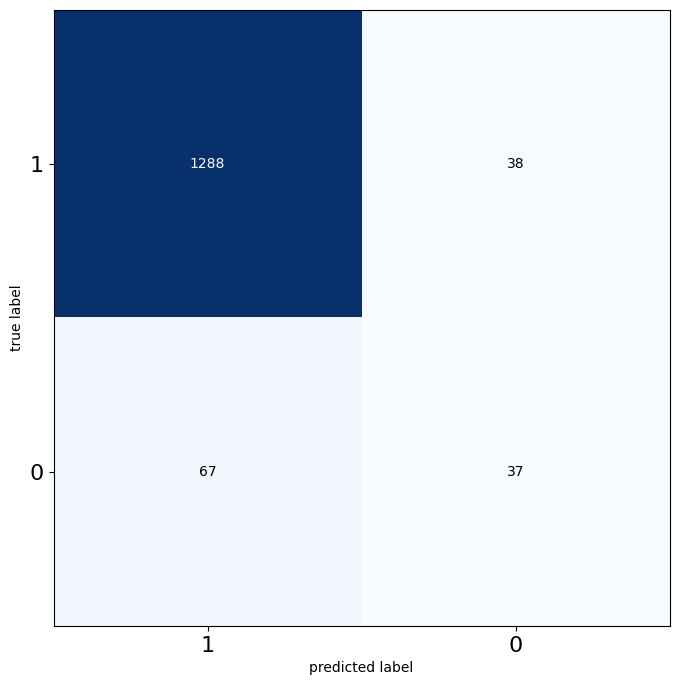

history
accuracy: 0.66993006993007 precision: 0.1047008547008547 recall: 0.4803921568627451 f1: 0.1719298245614035


<Figure size 640x480 with 0 Axes>

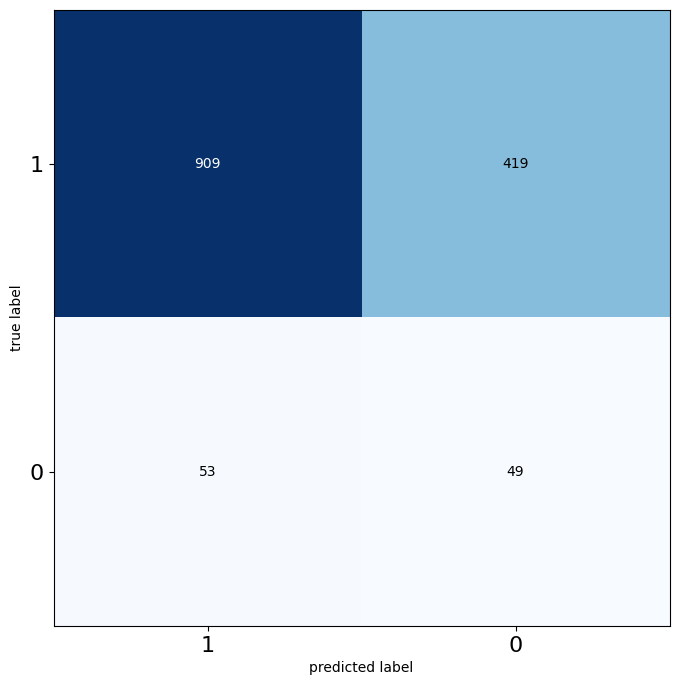

horror
accuracy: 0.7713286713286713 precision: 0.13293051359516617 recall: 0.5238095238095238 f1: 0.21204819277108436


<Figure size 640x480 with 0 Axes>

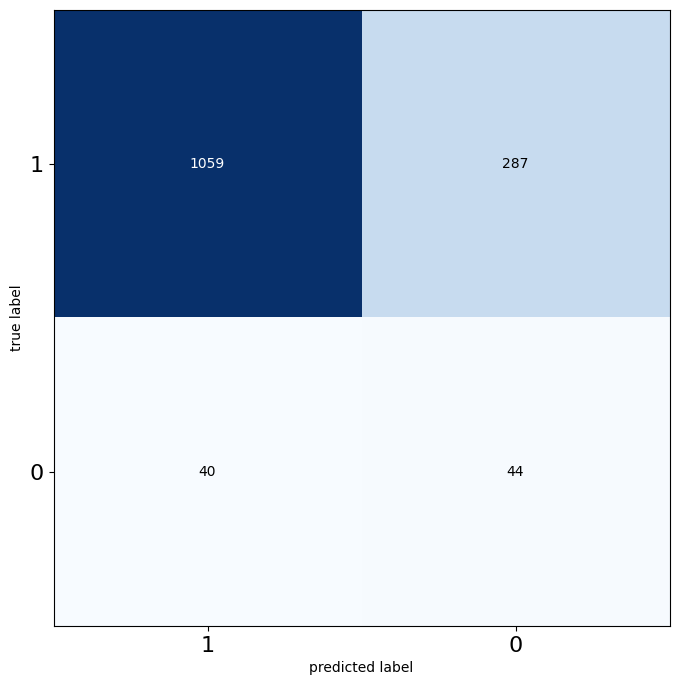

music
accuracy: 0.8447552447552448 precision: 0.14450867052023122 recall: 0.25252525252525254 f1: 0.18382352941176472


<Figure size 640x480 with 0 Axes>

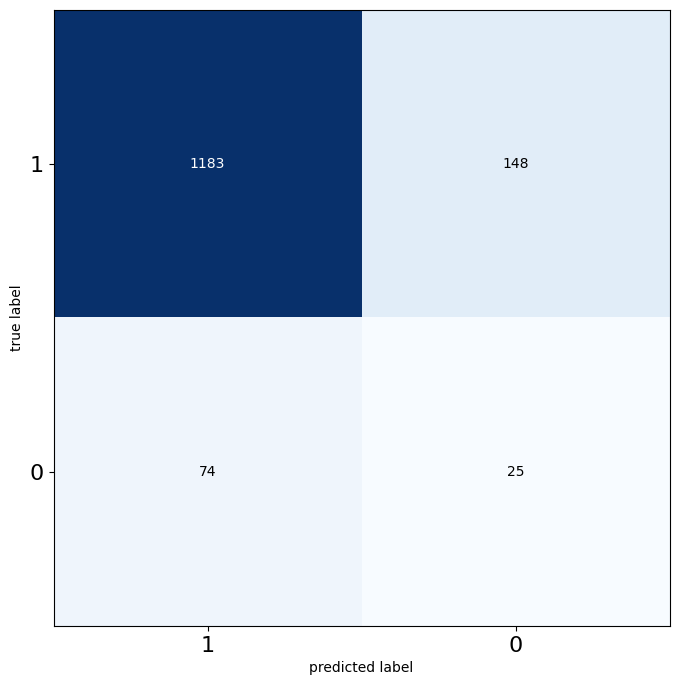

musical
accuracy: 0.8013986013986014 precision: 0.15272727272727274 recall: 0.45161290322580644 f1: 0.2282608695652174


<Figure size 640x480 with 0 Axes>

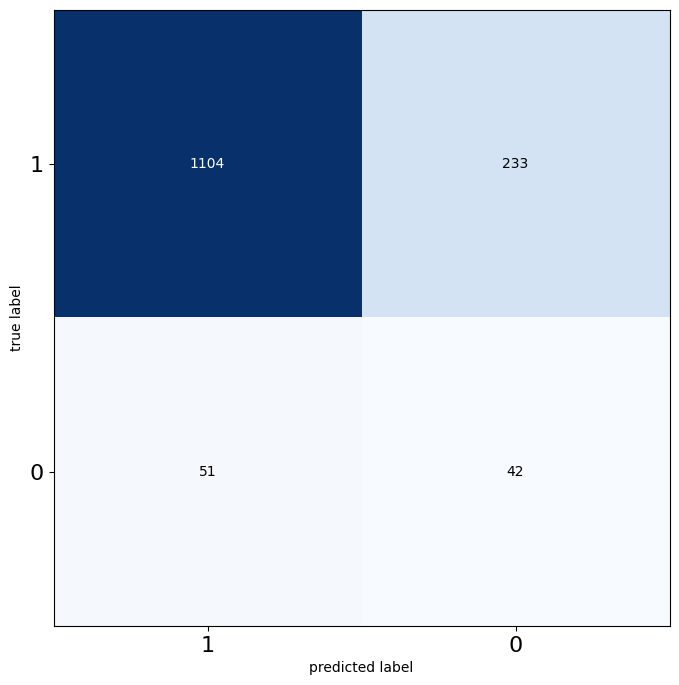

mystery
accuracy: 0.7524475524475525 precision: 0.1348973607038123 recall: 0.4380952380952381 f1: 0.20627802690582958


<Figure size 640x480 with 0 Axes>

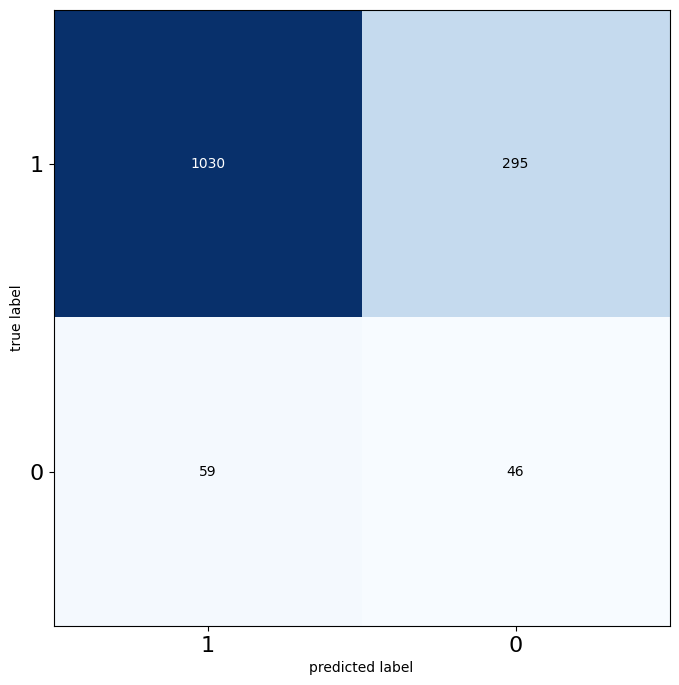

romance
accuracy: 0.6755244755244755 precision: 0.10869565217391304 recall: 0.4807692307692308 f1: 0.1773049645390071


<Figure size 640x480 with 0 Axes>

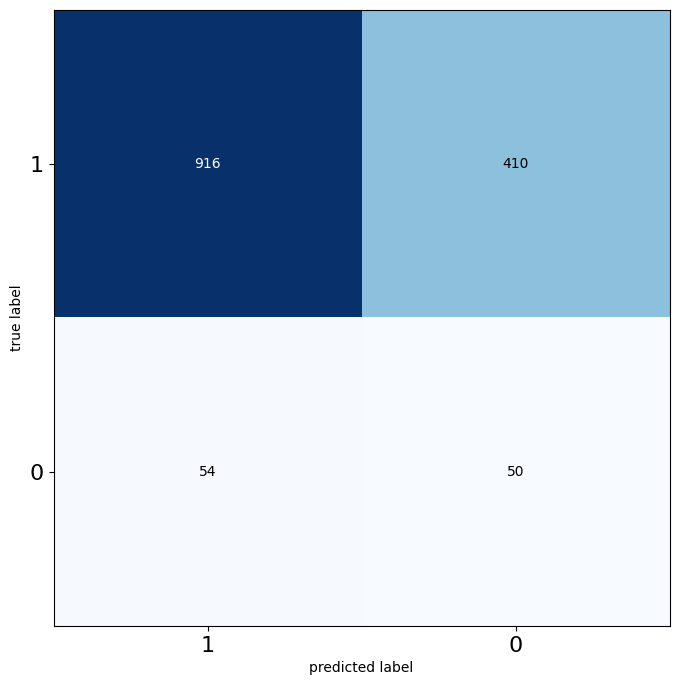

sci-fi
accuracy: 0.8608391608391608 precision: 0.18181818181818182 recall: 0.27722772277227725 f1: 0.2196078431372549


<Figure size 640x480 with 0 Axes>

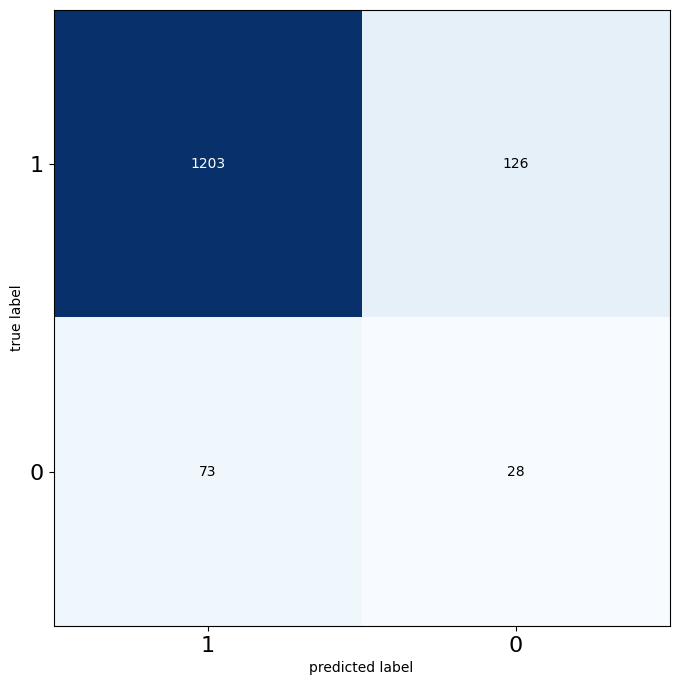

short film
accuracy: 0.7538461538461538 precision: 0.1565934065934066 recall: 0.5588235294117647 f1: 0.24463519313304724


<Figure size 640x480 with 0 Axes>

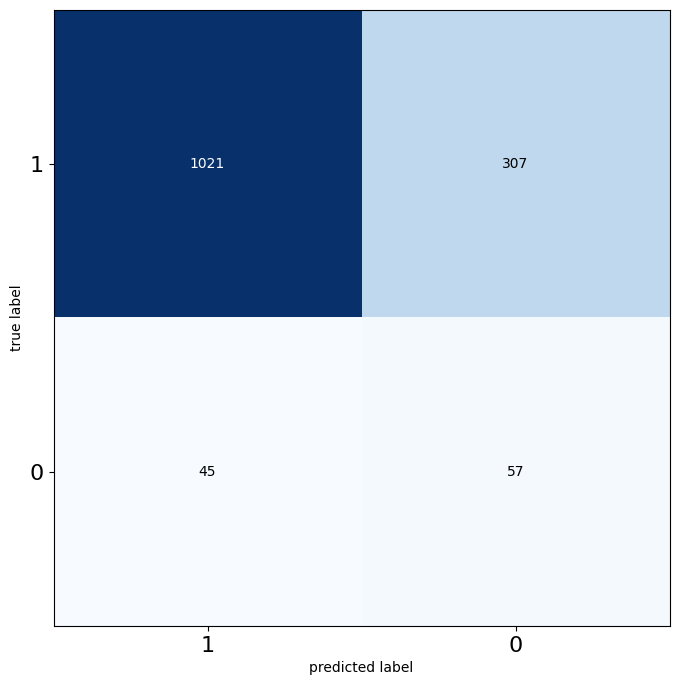

sport
accuracy: 0.6244755244755245 precision: 0.08888888888888889 recall: 0.5161290322580645 f1: 0.15165876777251186


<Figure size 640x480 with 0 Axes>

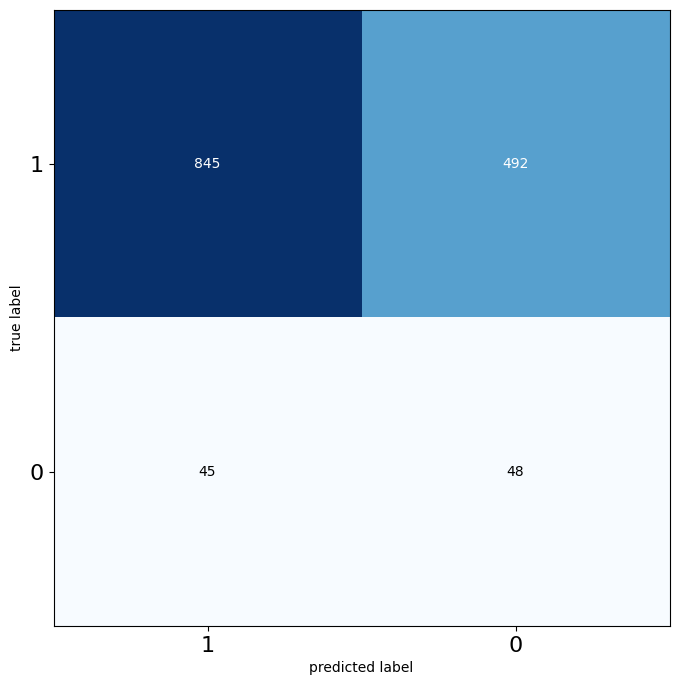

superhero
accuracy: 0.8846153846153846 precision: 0.16822429906542055 recall: 0.19148936170212766 f1: 0.1791044776119403


<Figure size 640x480 with 0 Axes>

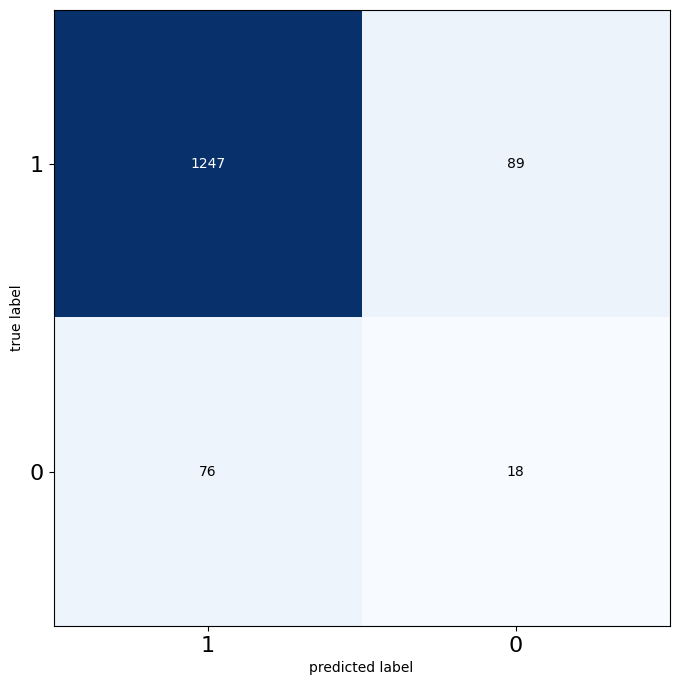

thriller
accuracy: 0.7580419580419581 precision: 0.12684365781710916 recall: 0.46236559139784944 f1: 0.1990740740740741


<Figure size 640x480 with 0 Axes>

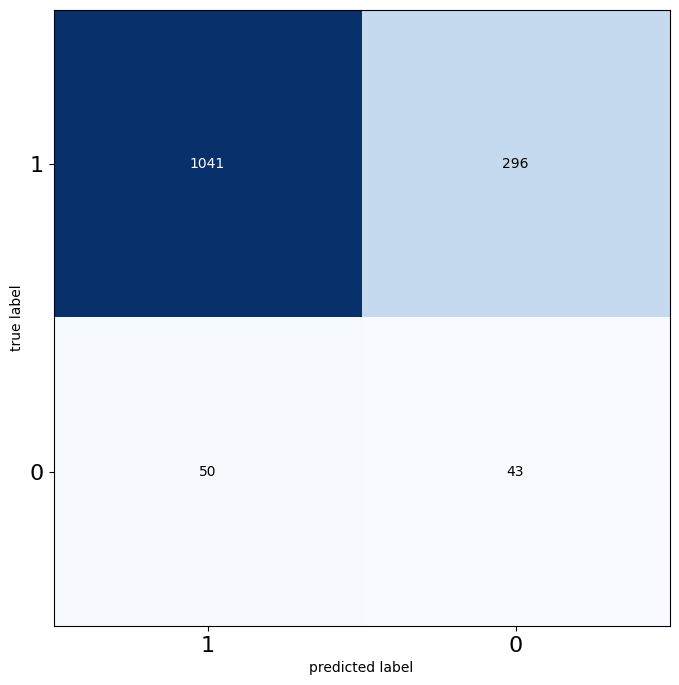

war
accuracy: 0.8195804195804196 precision: 0.12371134020618557 recall: 0.21428571428571427 f1: 0.1568627450980392


<Figure size 640x480 with 0 Axes>

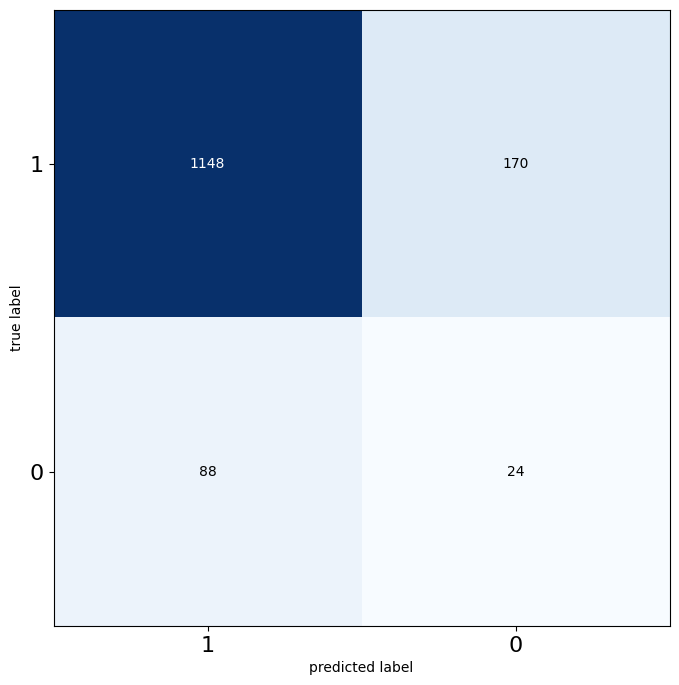

western
accuracy: 0.865034965034965 precision: 0.1328125 recall: 0.1717171717171717 f1: 0.14977973568281938


<Figure size 640x480 with 0 Axes>

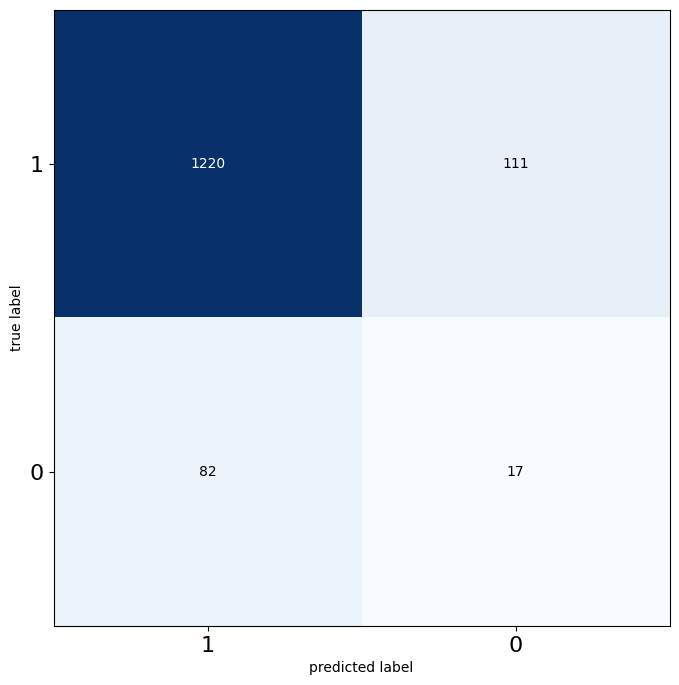

In [78]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
  # print(len(labels[i, :]), len(preds_2[i, :]))
  accuracy_per_class.append(accuracy_score(labels[i, :], preds_2[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds_2[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds_2[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds_2[i, :]))
  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])
  cm  = confusion_matrix(labels[i, :], preds_2[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=16)
  plt.yticks(range(2), ['1', '0'], fontsize=16)
  plt.show()

In [79]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.7849358974358974 Precision: 0.1600844367307633 Recall: 0.3994538968464112 f1: 0.21027810326348462
